# <center>Исследование компьютерных игр, 2016 год</center>

## <center>Содержание</center>

<br>**Введение**
<br>**Импорт библиотек**
<br>**Предобработка данных**
<br>**Анализ данных**
+ Портреты пользователей по регионам

<br>**Проверка гипотез**
+ Пользовательские рейтинги на XOne и PC
+ Пользовательские рейтинги жанров экши и спорт

<br>**Общий вывод**

## <center>Введение</center>

Целью работы является исследование компьютерных игр за 2016 год для определения закономерностей, позволяющих предположить успех (или неудачу) игры. Датасет содержит следующую информацию: название игры `Name`, платформа `Platform`, год выпуска `Year_of_Release`, жанр `Genre`, продажи в миллионах копий:
* `NA_sales` — Северная Америка;
* `EU_sales` — Европа;
* `JP_sales` — Япония;
* `Other_sales` — другие страны;

<br>Оценки игр:
* `Critic_Score` — критики (до 100)
* `User_Score` — пользователи (до 10)

<br>И рейтинг ESRB `Rating`.
Данные за 2016 год могут быть неполными. 

## <center>Импорт библиотек</center>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st

## <center>Предобработка данных</center>

Посмотрим, с чем мы имеем дело - так как проверять датафрейм(ы) мы будем часто, сразу напишем функцию, выводящую первые 10 строк датафрейма и информацию о нём:

In [2]:
def data_info(df):
    display(df.head(10))
    print(df.info())

И перейдём к нашим данным:

In [3]:
data_games = pd.read_csv('games.csv')
data_info(data_games)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Да, проблемы есть: год и оценки критиков из-за наличия пропусков стали float; а оценки пользователей - это строка. Такое нам не нужно - будем разбираться по порядку. Для начала просто переведём названия столбцов в нижний регистр:

In [4]:
data_games.columns = data_games.columns.str.lower()
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Посмотрим на столбец с названиями - здесь сразу видна... не то чтобы проблема, но специфика записи: `New Super Mario Bros.` и `New Super Mario Bros. Wii` - это как бы две разные игры, хотя это одна игра на разных платформах. С этим пока что делать ничего не будем - просто запомним, что такое есть. Также здесь имеются два пропуска - посмотрим на них:

In [5]:
display(data_games[data_games['name'].isnull()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Какие-то странные и малоинформативные строки в принципе - избавимся от них:

In [6]:
data_games = data_games.dropna(subset=['name']).reset_index(drop=True)
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Отлично. Посмотрим, какие у нас есть платформы:

In [7]:
display(data_games['platform'].value_counts())

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

Некоторые платформы давно уже умерли, но ничего "нереального" в этом столбце вроде нет, едем дальше. 

Ситуация с пропусками в годе релиза загадочна: не очень ясно, откуда здесь могли взяться пропуски. Посмотрим:

In [8]:
display(data_games[data_games['year_of_release'].isnull()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


У некоторых игр (например, Hakuouki: Shinsengumi Kitan) год просто не указан и сделать с этим ничего нельзя (если не гуглить и не заполнять вручную). А у спортивных игр год есть в названии - только обычно они выходят на год раньше, то есть нужно вычесть единицу. Сделаем следующее: если год имеется в названии, вытащим его, а если нет, то заполним заглушкой "-1":

In [9]:
#в функцию будем передавать год релиза и название игры
def year_filler(year, name, genre):
    if np.isnan(year):
        #если год - NaN, то пробуем вытащить дату из названия; если не выходит, то -1
        try:
            year_from_name = float(re.search('\d{4}', name).group(0))
            if (genre == "Sports"):
                return (year_from_name - 1)
            else:
                return year_from_name
        except:
            return -1
    else:
        return year


data_games['year_of_release'] = data_games.apply(lambda x: year_filler(x['year_of_release'], x['name'], x['genre']), axis=1)
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Замечательно - год заполнился. Есть, правда, один нюанс: наша реализация срежется, если некий год (или в принципе 4-хзначное число) заложен в название игры - например, реально существующая игра The Order: 1886. Из записи `The Order: 1886 2015` как год релиза вытащится 1886. Посмотрим, появилось ли у нас после заполнения что-то странное:

In [10]:
display(data_games[(data_games['year_of_release'] > -1) & 
                   ((data_games['year_of_release'] < 1980) | (data_games['year_of_release'] > 2016))])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Вроде всё в порядке - осталось перевести в целочисленный тип:

In [11]:
data_games['year_of_release'] = data_games['year_of_release'].astype('int64')
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB
None


Победа разума - посмотрим, что у нас есть в жанрах:

In [12]:
display(data_games['genre'].value_counts())

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Отлично: всё прилично, без дубликатов из-за регистра и идейных типа `Role-Playing` и `RPG`. Едем дальше: в `na_sales`, `eu_sales`, `jp_sales` и `other_sales` нет пропусков и с типом всё в порядке, их пропускаем. В `critic_score`, то есть оценках критиков, пропусков много - устраивать гадание на кофейной гуще и заполнять какими-либо средними/медианами не кажется мне осмысленным. Заполним заглушкой "-1" и приведём к целочисленному типу: 

In [13]:
data_games['critic_score'] = data_games['critic_score'].fillna(-1).astype('int64')
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 1.4+ MB
None


С `user_score`, то есть оценками пользователей, история странная - почему строки? Посмотрим, что там есть в принципе:

In [14]:
print(data_games['user_score'].value_counts())

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64


Ага! `tbd` - то есть to be determined/declared, что переводится как "информация будет (объявлена) позже". Вот это `tbd` нам нужно заменить на -1, а также заполнить пропуски той же -1:

In [15]:
data_games.loc[data_games['user_score'] == 'tbd', 'user_score'] = '-1'
data_games['user_score'] = data_games['user_score'].fillna('-1').astype('float64')
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB
None


Остался рейтинг: посмотрим, что у нас есть в принципе и у каких записей стоят пропуски:

In [16]:
display(data_games['rating'].value_counts())
display(data_games[data_games['rating'].isnull()].head(20))

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,-1,-1.0,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,9.00,6.18,7.20,0.71,-1,-1.0,NaN
18,Super Mario World,SNES,1990,Platform,12.78,3.75,3.54,0.55,-1,-1.0,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,-1,-1.0,NaN
21,Super Mario Land,GB,1989,Platform,10.83,2.71,4.18,0.42,-1,-1.0,NaN
22,Super Mario Bros. 3,NES,1988,Platform,9.54,3.44,3.84,0.46,-1,-1.0,NaN


У меня было предположение, что рейтинг отсутствует у игр "для всех", то есть пропуски можно заменить на "E" - но `Call of Duty: Black Ops 3` его разбил xD Здесь история сложнее.

EC и K-A - это устревшие рейтинги, которые означают "E". Их можно было бы заменить на "E" - но можно и оставить; пока оставим. AO игр - Adults Only, 18+ - в принципе немного; неудивительно, что в таблице она одна, это нормально. RP - это Rating Pending, то есть над ним ещё думают, информации нет. Заполнять пропуски значением "RP" не кажется мне хорошей идеей: пропуски у нас имеются и у старых игр, где явно уже не думают, рейтинг определён - информации просто нет. И игры с настоящими пропусками очень разнородны: то Покемоны, то Колда. Здесь тоже просто поставим -1:

In [17]:
data_games['rating'] = data_games['rating'].fillna('-1')
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,-1
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,-1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB
None


Добавим суммарные продажи по регионам:

In [18]:
data_games['sum_sales'] = (data_games['na_sales'] + data_games['eu_sales'] 
                           + data_games['jp_sales'] + data_games['other_sales'])
data_info(data_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1,-1.0,-1,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1,-1.0,-1,28.31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  sum_sales        16713 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.5+ MB
None


Отлично! На этом предобработка данных завершена.

## <center>Анализ данных</center>

Посмотрим, сколько игр выпускалось в разные годы - и оценим распределение. Так как межквартильный размах нам ещё понадобится, вынесем подсчёт в функцию:

In [19]:
def distr_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    l_border = Q1 - 1.5 * IQR
    r_border = Q3 + 1.5 * IQR
    print(f'Левая граница: {l_border: .3f}, правая граница: {r_border: .3f}')

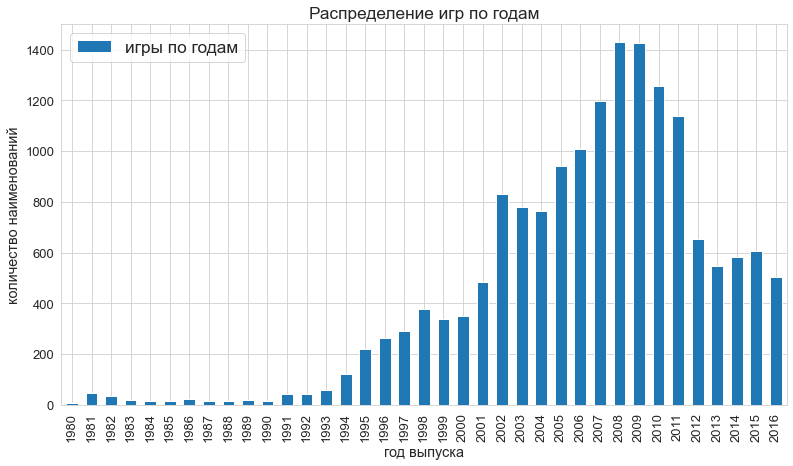

Левая граница:  1992.500, правая граница:  2020.500


count    16461.000000
mean      2006.484904
std          5.873554
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [20]:
sns.set_style("whitegrid")
data_years = data_games.query('year_of_release > 0')

data_years.pivot_table(index='year_of_release', values='name', aggfunc='count').plot.bar(
    y='name', width=0.6, figsize=(13, 7), label='игры по годам')
plt.legend(loc='upper left', fontsize="xx-large")
plt.xlabel('год выпуска', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.title('Распределение игр по годам', fontsize="xx-large")
plt.show()
    
distr_iqr(data_years['year_of_release'])
data_years['year_of_release'].describe()

Глобально нас интересовал бы период с 1993 по 2016 год - но это глобально. (И здесь стоит вспомнить о том, что некоторые игры мы считаем по нескольку раз - несколько версий для разных платформ идут как разные игры). Посмотрим распределения по платформам:

In [21]:
pivot_platforms_top = data_games.query('year_of_release > 0').pivot_table(
    index='platform', values='sum_sales', aggfunc='sum').sort_values(
    by='sum_sales', ascending=False)
display(pivot_platforms_top)

,sum_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


Любопытно, что PC - это даже не топ-10 :) Рассмотрим **вообще все** платформы - наш массив отсортирован в порядке убывания суммарных продаж, так что нижеследующие графики идут **в порядке убывания суммарных продаж**:

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
2007,0.0,0.0,0.0,1.0,377.0,0.0,6.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,185.0,0.0,123.0,3.0,0.0
2008,0.0,0.0,0.0,1.0,492.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,282.0,0.0,146.0,1.0,0.0
2009,0.0,0.0,0.0,0.0,403.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,325.0,0.0,172.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,323.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,253.0,0.0,182.0,0.0,0.0
2011,0.0,0.0,116.0,0.0,153.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,143.0,0.0,207.0,0.0,0.0
2012,0.0,0.0,93.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,32.0,106.0,0.0,0.0
2013,0.0,0.0,91.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,42.0,75.0,0.0,19.0
2014,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,31.0,63.0,0.0,61.0
2015,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,28.0,35.0,0.0,80.0


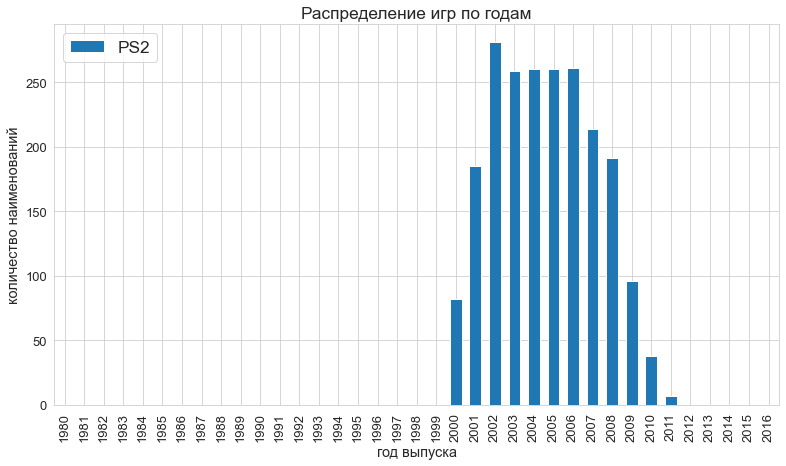

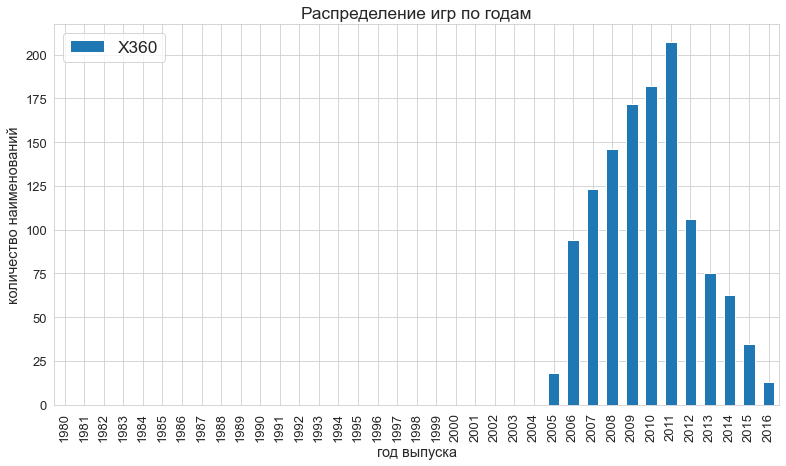

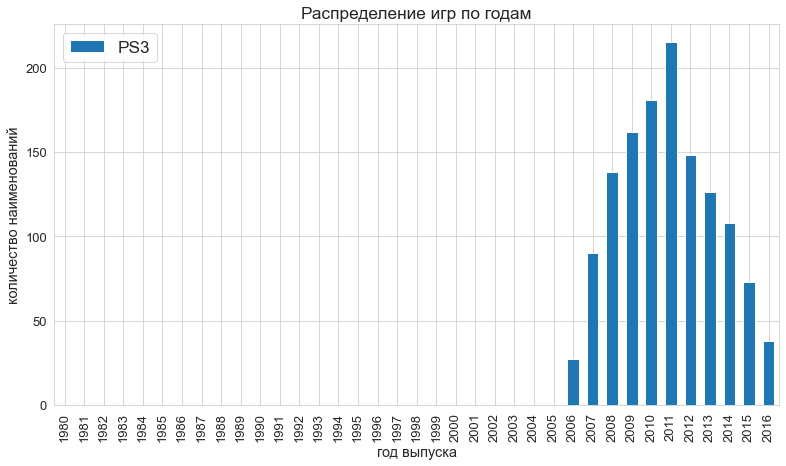

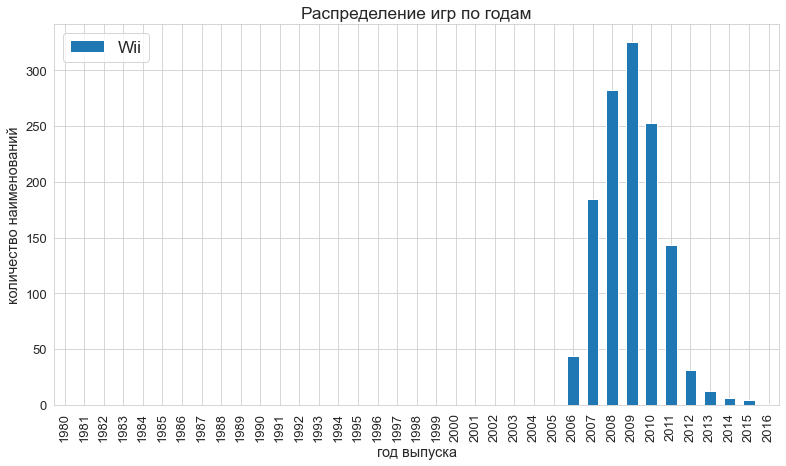

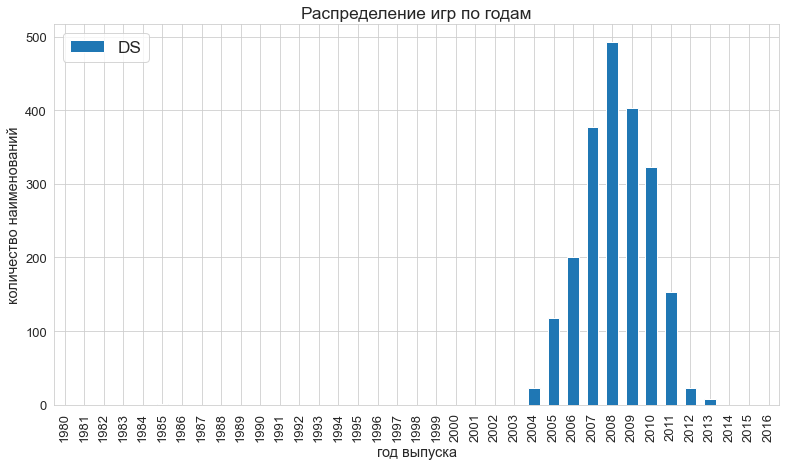

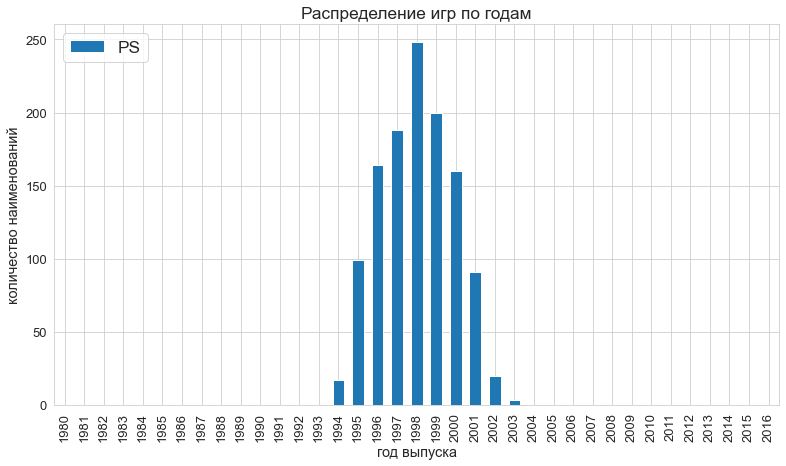

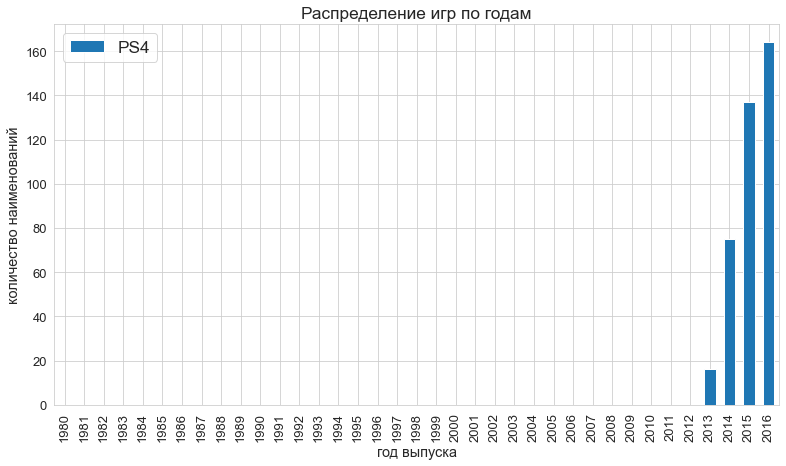

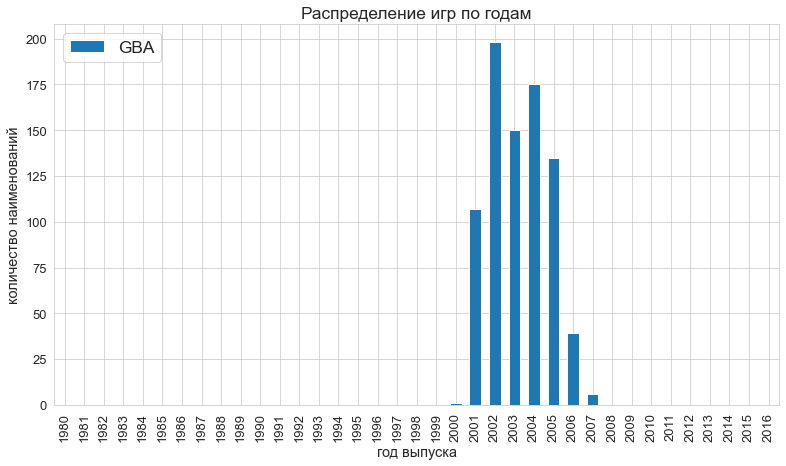

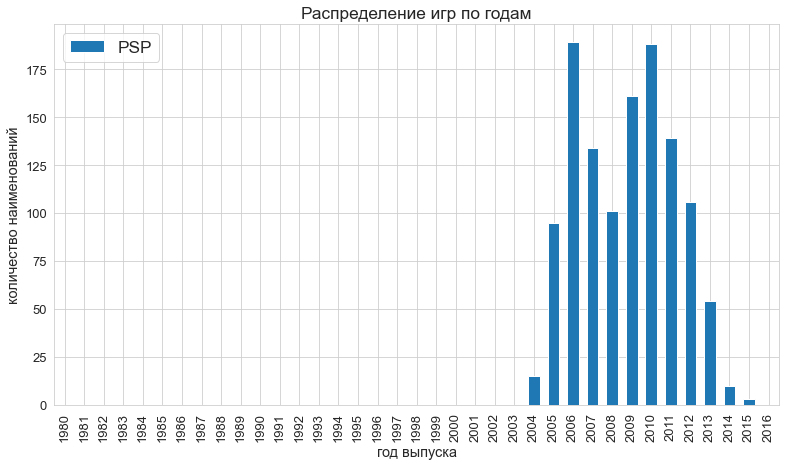

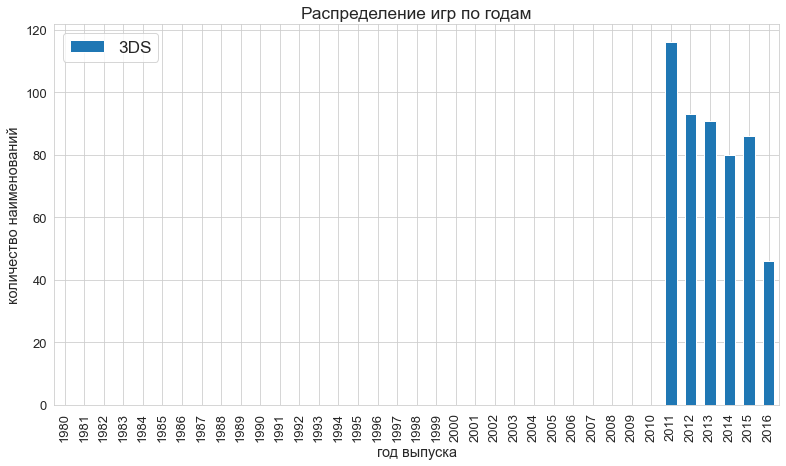

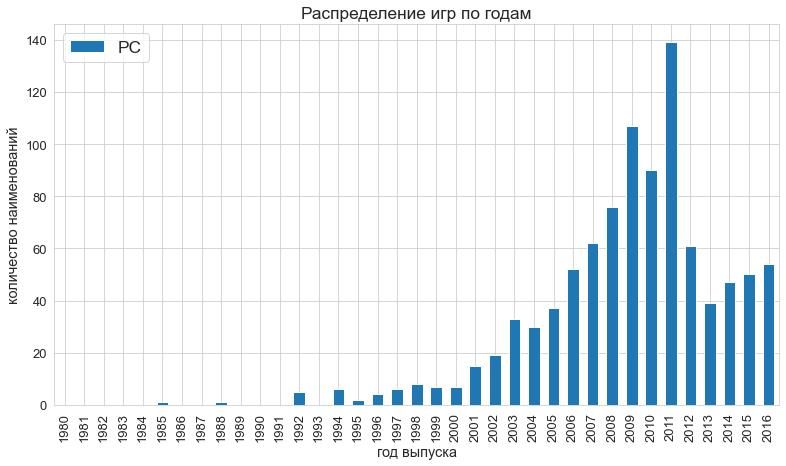

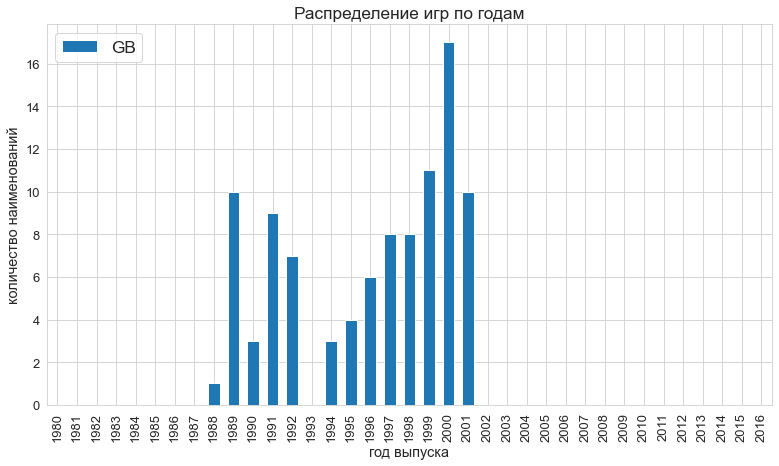

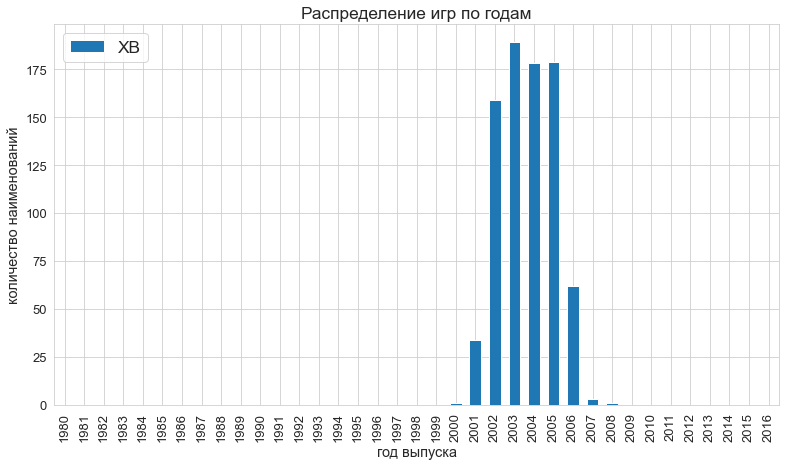

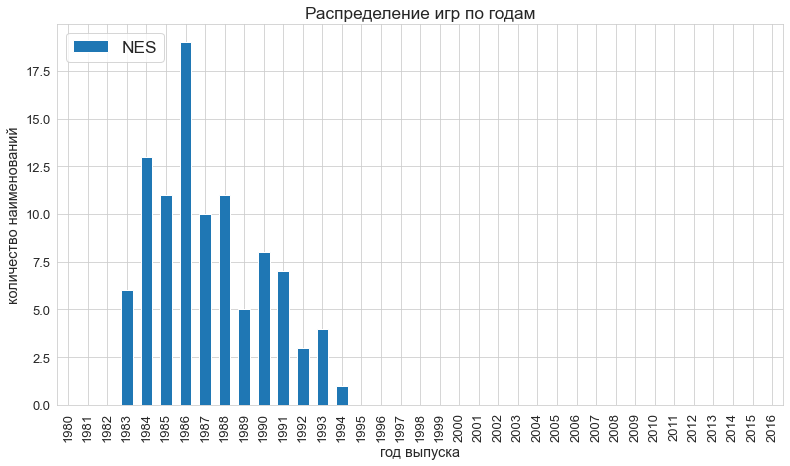

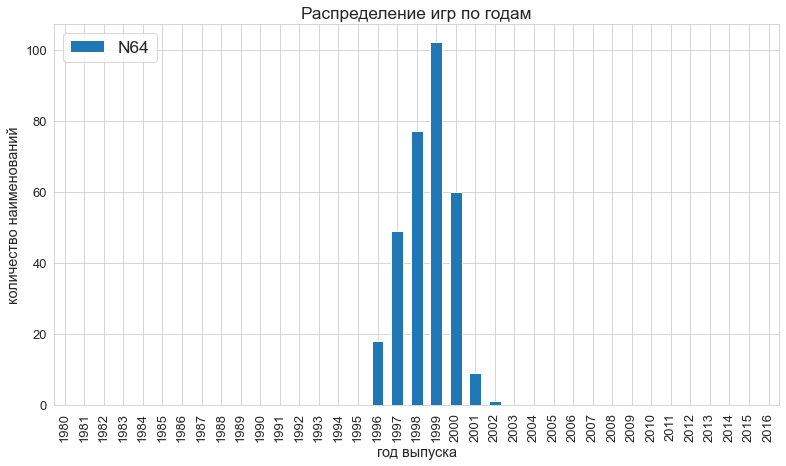

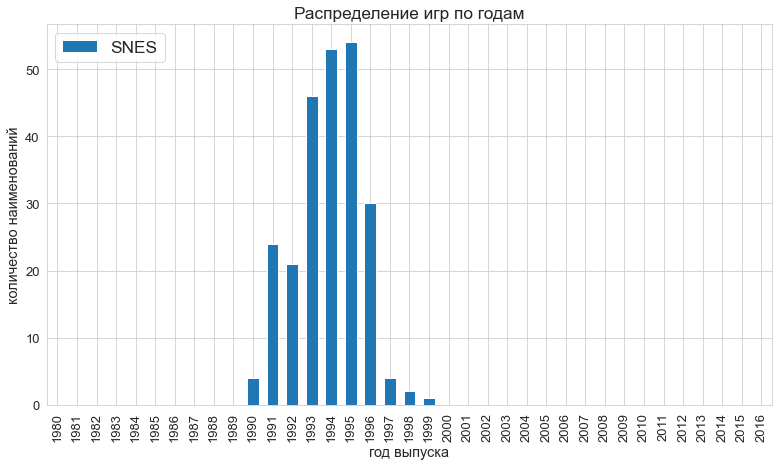

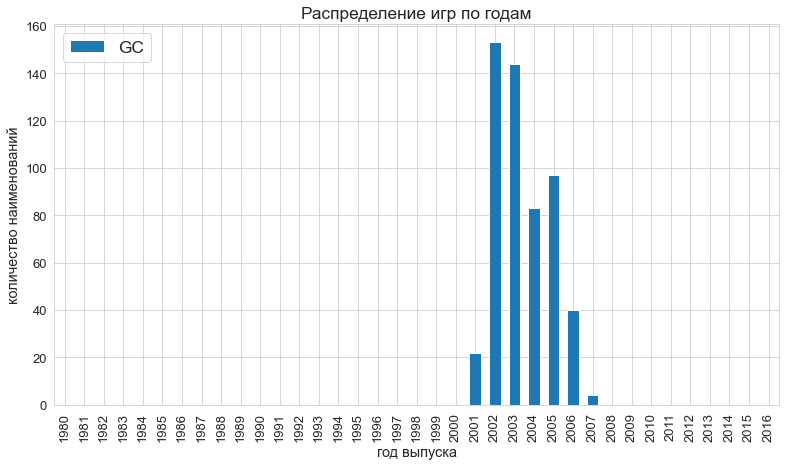

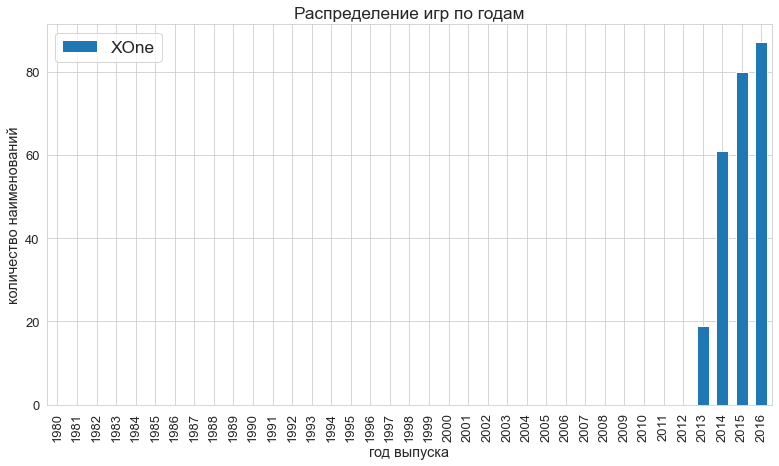

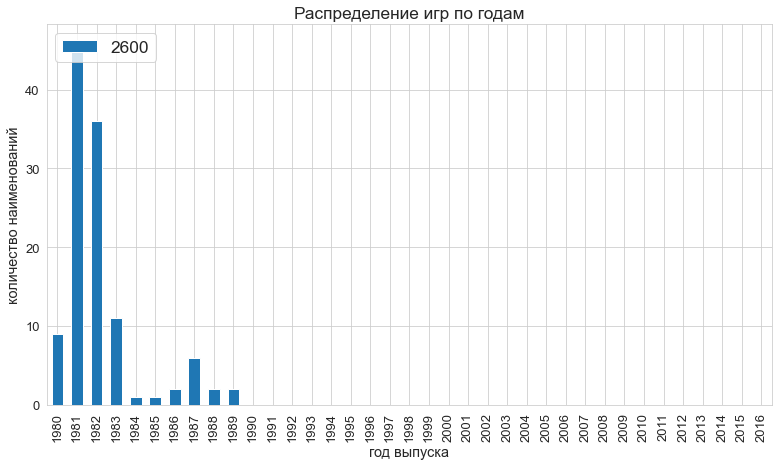

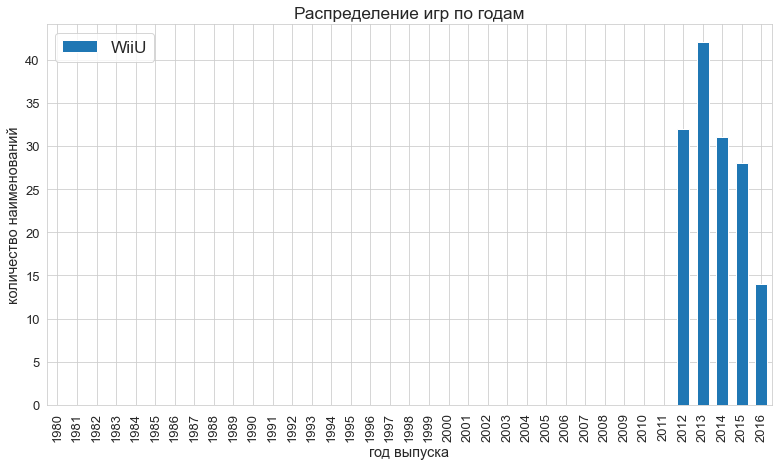

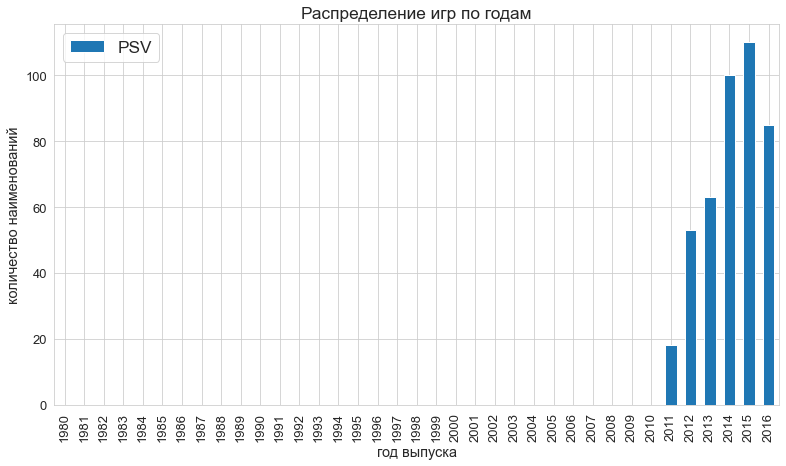

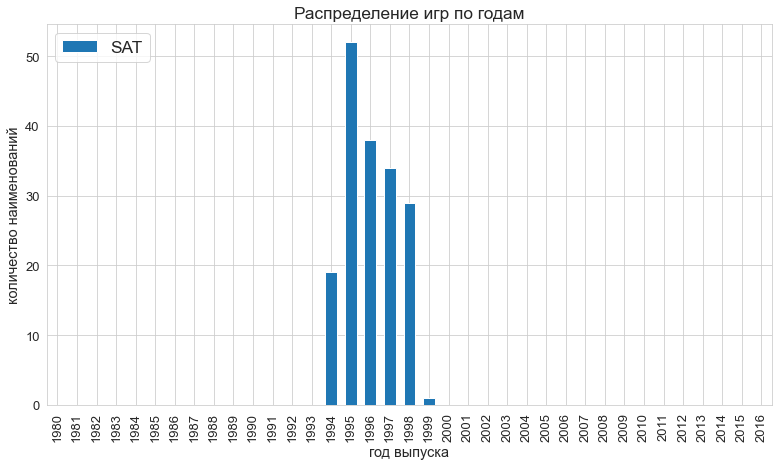

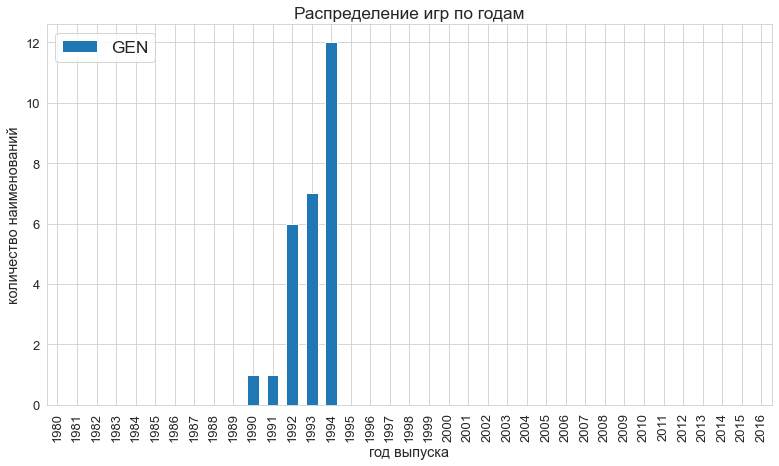

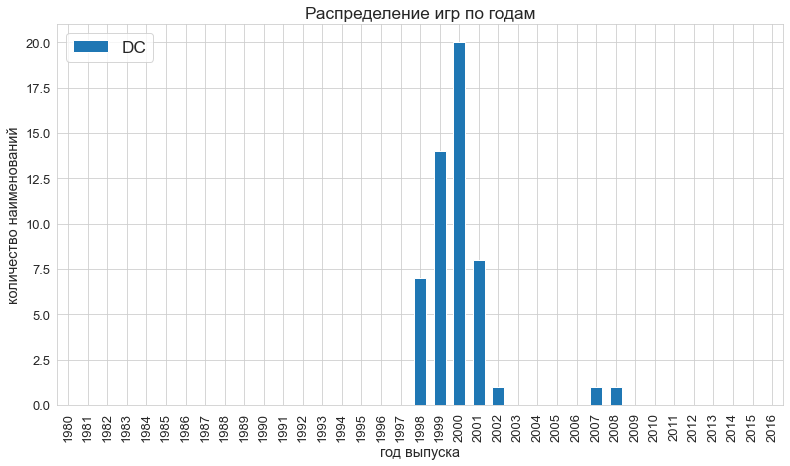

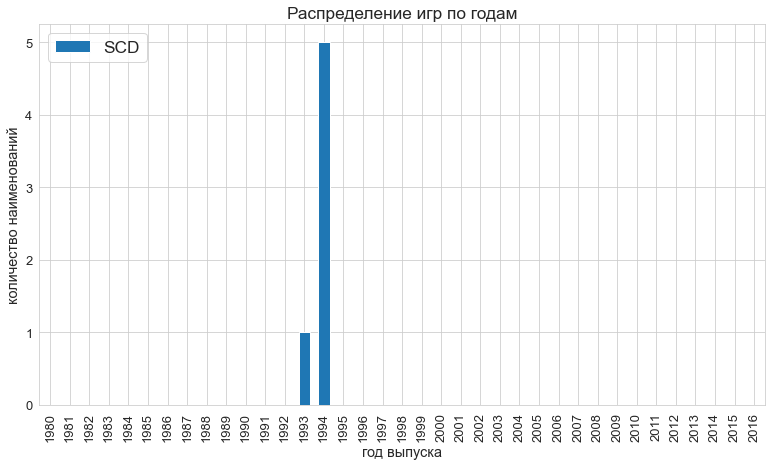

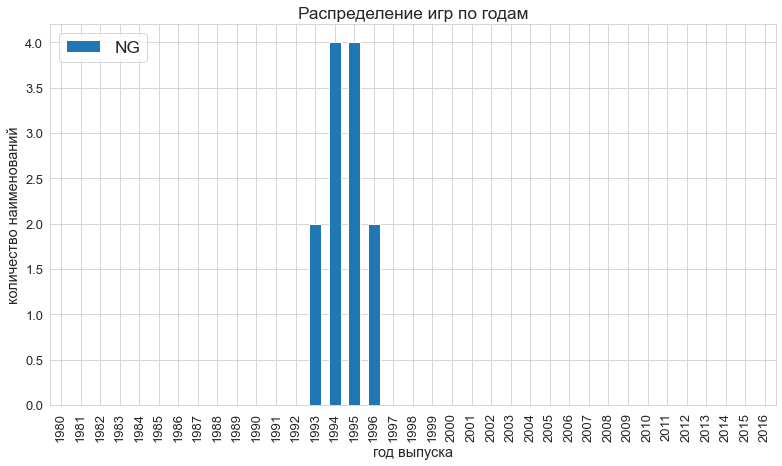

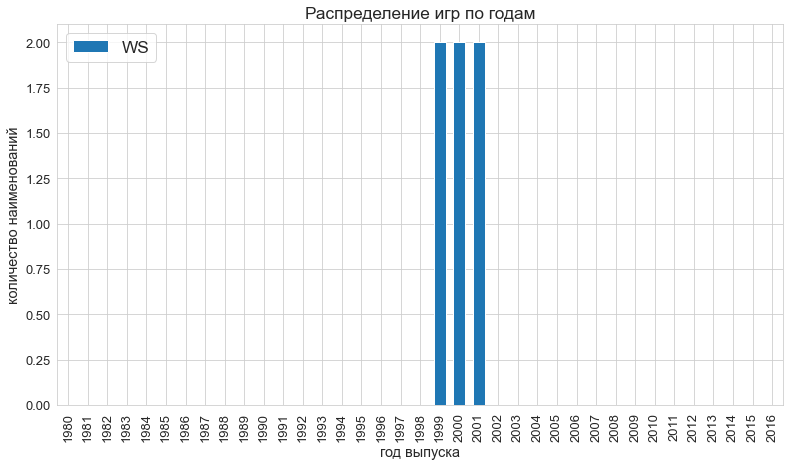

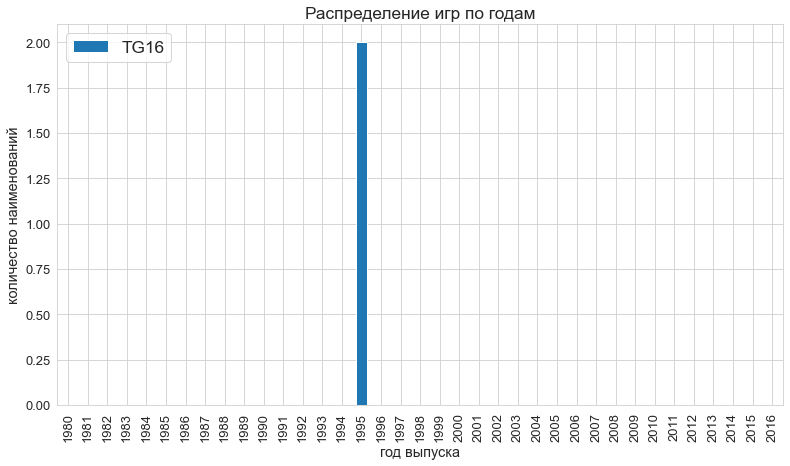

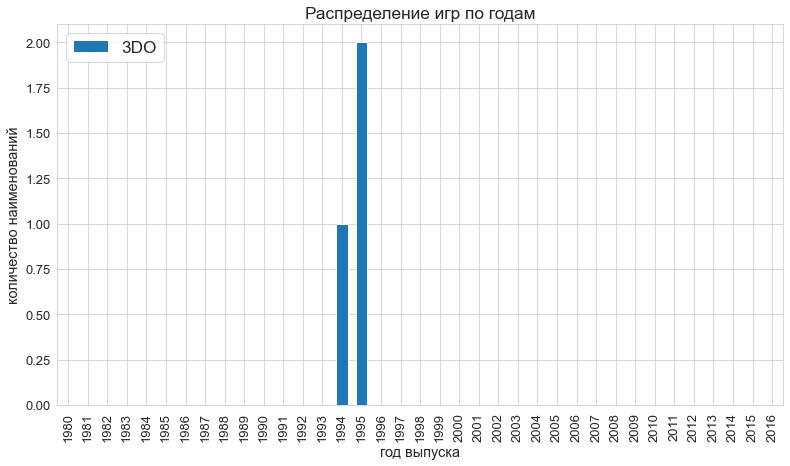

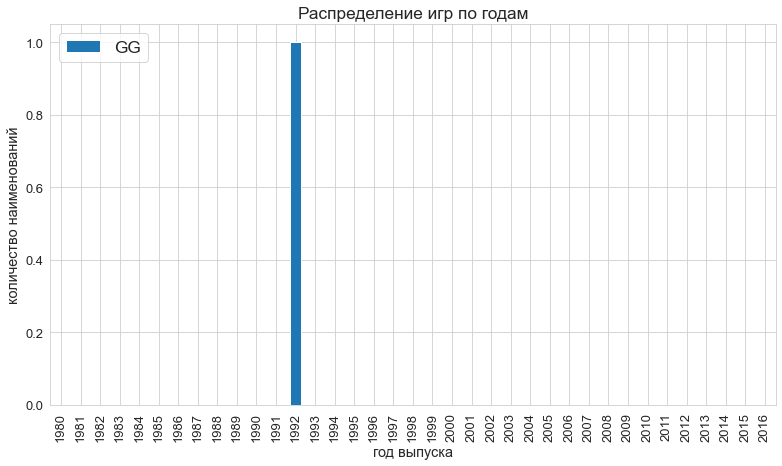

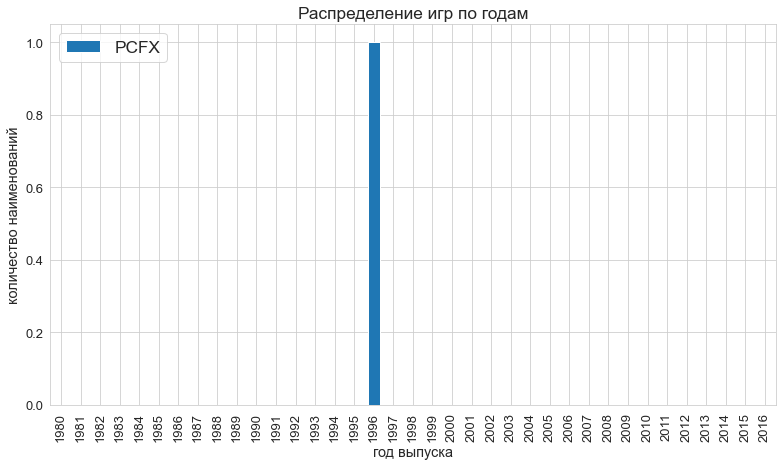

In [22]:
pivot_platforms = data_games.query('year_of_release > 0').pivot_table(
    index='year_of_release', columns='platform', values='name', aggfunc='count').fillna(0)
display(pivot_platforms.tail(10))

for platform in pivot_platforms_top.index:
    pivot_platforms.plot.bar(y=platform, width=0.6, figsize=(13, 7), label=platform)
    plt.legend(loc='upper left', fontsize="xx-large")
    plt.title('Распределение игр по годам', fontsize="xx-large")
    plt.xlabel('год выпуска', fontsize="x-large")
    plt.ylabel('количество наименований', fontsize="x-large")
    plt.xticks(size = 13)
    plt.yticks(size = 13)
    plt.show()

По этим распределениям я бы сказала, что **в среднем жизненный цикл платформы составляет 7-10 лет**. Новыми, ныне растущими, потенциально прибыльными платформами являются `PS4` и `XOne`. `X360` и `PS3` ещё живы, но агонизируют (игр на них делается всё меньше). `Wii`, `DS` и `PSP` уже умерли; `3DS` и `WiiU` просели в 2016-м, как и `PSV` - однако на `PSV` количество тайтлов остаётся внушительным (`3DS` просела очень сильно, а `WiiU` изначально получилась сравнительно нишевой). Впрочем, здесь стоит вспомнить о том, что данные за 2016 год могут быть неполными (!) - это важно.

Отдельным пунктом идёт `PC` - не самый прибыльный, но стабильный. Остальное - уже совсем древние истории. 

Эти выводы мы проверим, когда будем смотреть на обрезанные данные. 

Исходя из жизненного цикла, я сказала бы, что **актуальным периодом** - то есть периодом, который нас интересует - являются последние четыре года, то есть период **2012-2016 гг**. 

In [23]:
#обрезка и группировки
data_games_new = data_games.query('year_of_release >= 2012')
pivot_platforms_top_new = data_games_new.pivot_table(
    index='platform', values='sum_sales', aggfunc='sum').sort_values(
    by='sum_sales', ascending=False)
pivot_platforms_new = data_games_new.pivot_table(
    index='year_of_release', columns='platform', values='name', aggfunc='count').fillna(0)

display(pivot_platforms_top_new)

,sum_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,63.00
PSV,49.18
Wii,35.37


Картина изменилась любопытным образом - посмотрим актуальные распределения тайтлов по годам для разных платформ; графики всё также идут **в порядке убывания суммарных продаж**:

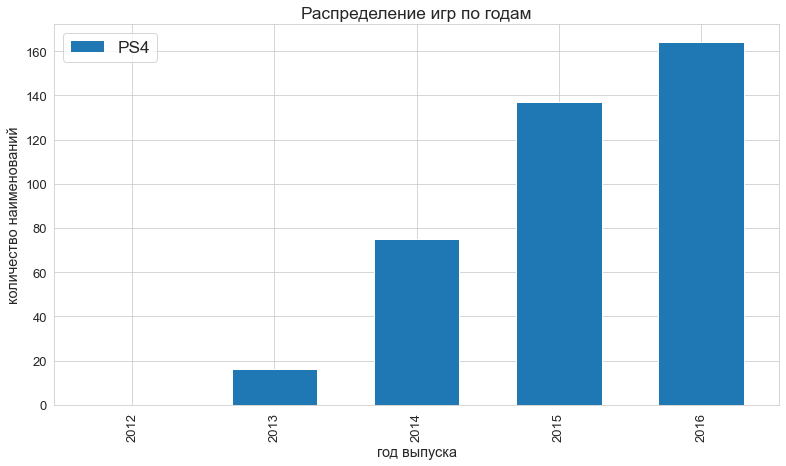

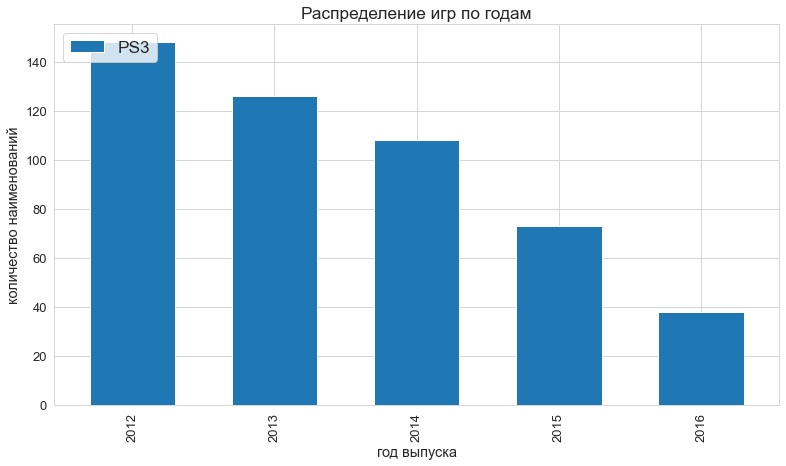

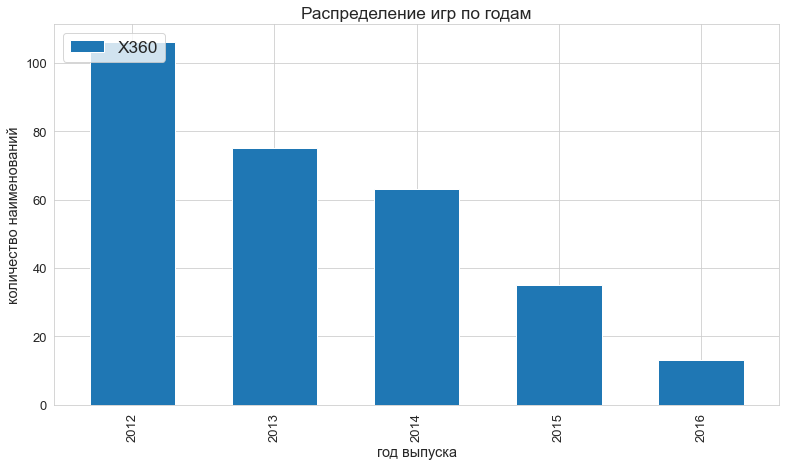

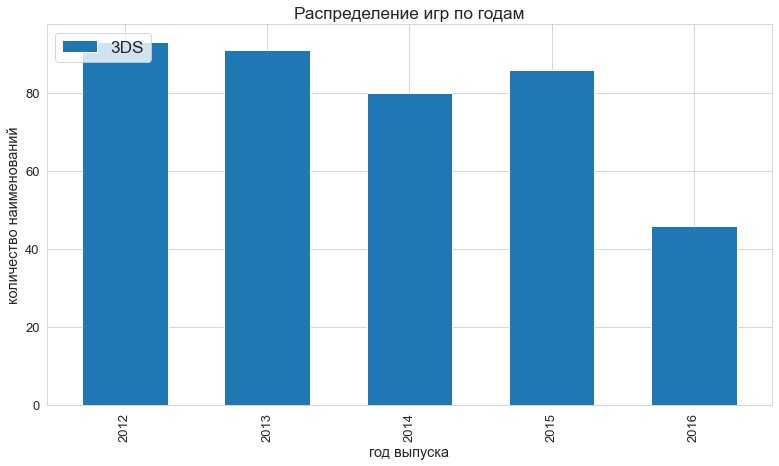

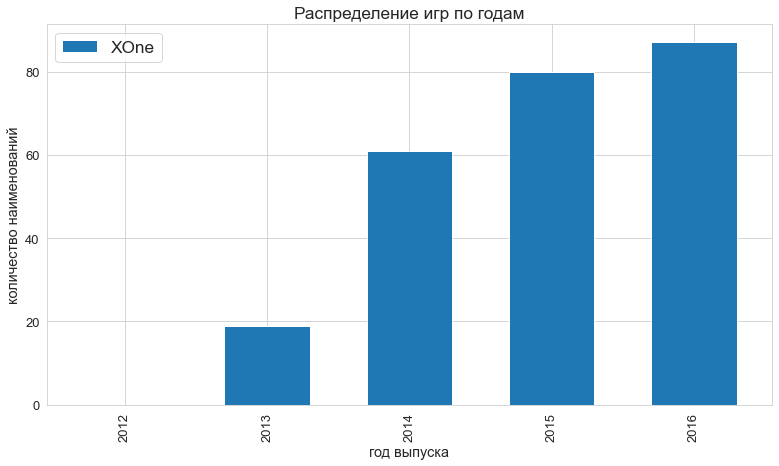

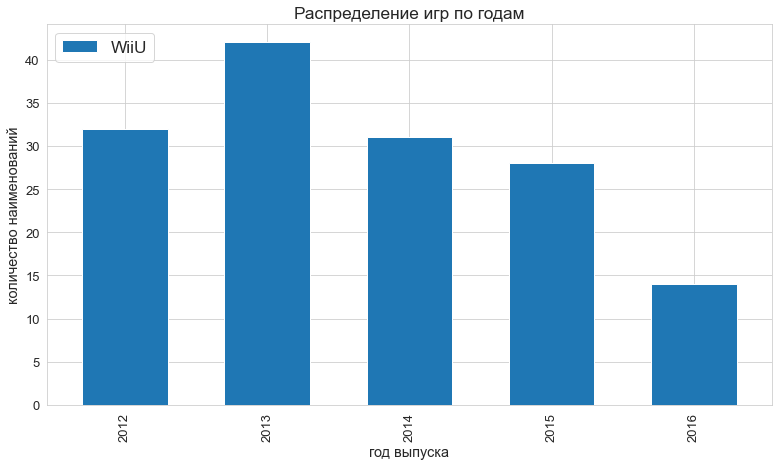

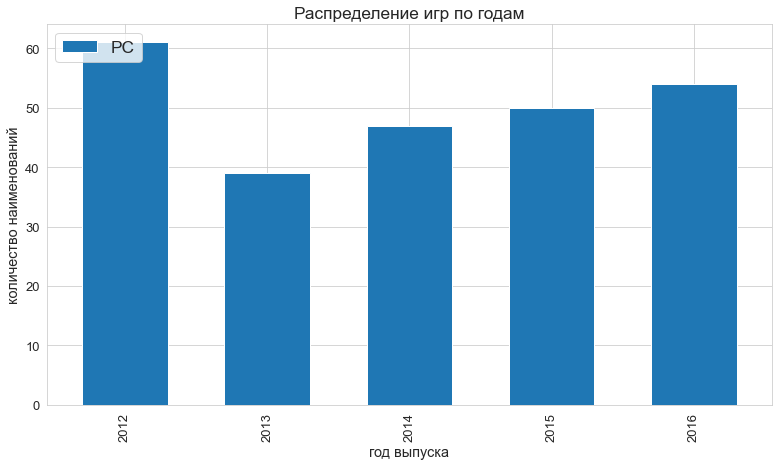

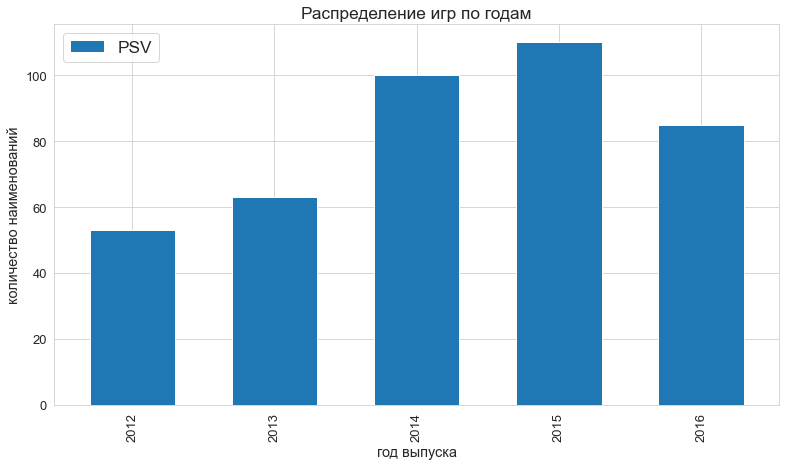

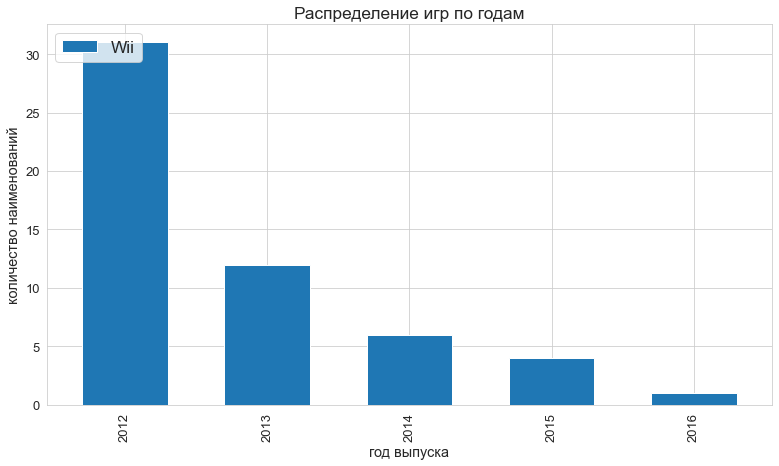

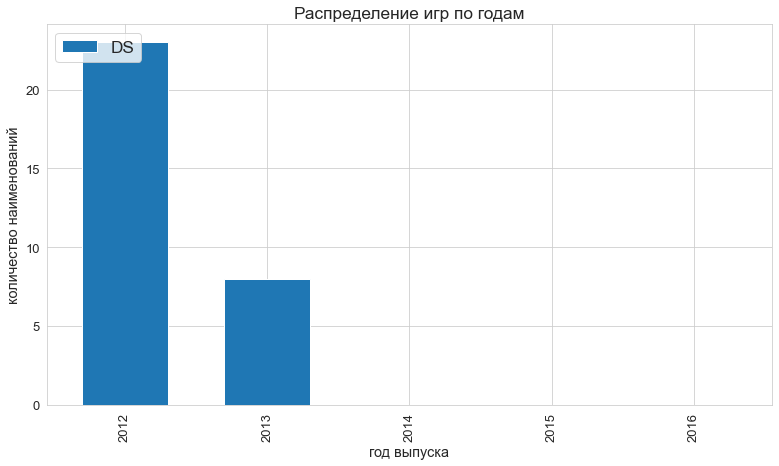

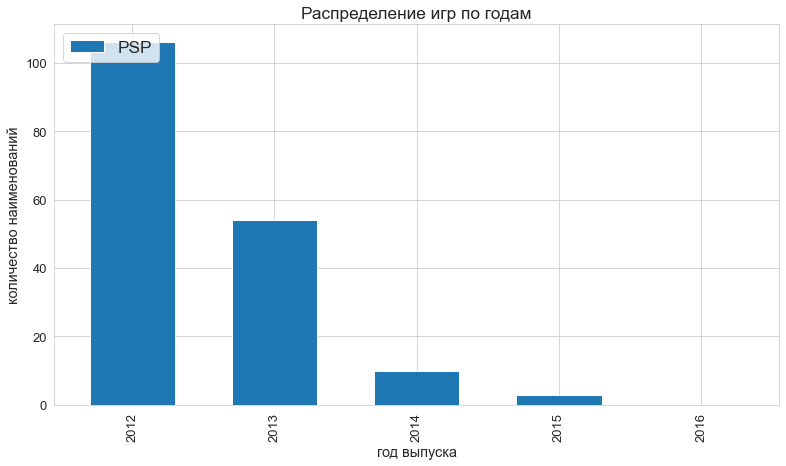

In [24]:
for platform in pivot_platforms_top_new.index:
    pivot_platforms_new.plot.bar(y=platform, width=0.6, figsize=(13, 7), label=platform)
    plt.legend(loc='upper left', fontsize="xx-large")
    plt.title('Распределение игр по годам', fontsize="xx-large")
    plt.xlabel('год выпуска', fontsize="x-large")
    plt.ylabel('количество наименований', fontsize="x-large")
    plt.xticks(size = 13)
    plt.yticks(size = 13)
    plt.show()

Уточним вывод: из 2016 года можно было бы сказать, что потенциально прибыльными растущими платформами являются `PS4` и `XOne`, на них определённо стоит сделать ставку (особенно на `PS4`, продажи прекрасны). `WiiU` падает уже не первый год (при этом и максимум тайтлов, который на ней был - это, в сравнении, не то чтобы много); `3DS` является определённой зоной риска - проседание может быть обосновано банальной неполнотой данных за 2016-й год... а может и не быть (консоли уже пять лет - она "зрелая" и может начать падать в тайтлах; но в ближайшие год-два умрёт вряд ли). Всё же я бы сказала, что торопиться сбрасывать `3DS` со счетов не стоит - как и `PCV`. `PS3` и `X360` же почти мертвы - `DS` и `PSP` уже совсем мертвы. `PC` не самый прибыльный, но стабилен и в разрезе тайтлов растёт после просадки в 2013.

**Итого остаются**: `PS4`, `XOne`, `PC`, `3DS`, `PCV`.

Дальше посмотрим **глобальные продажи игр в разбивке по платформам**: и в виде боксплота, и просто распределение - сначала просто распределения:

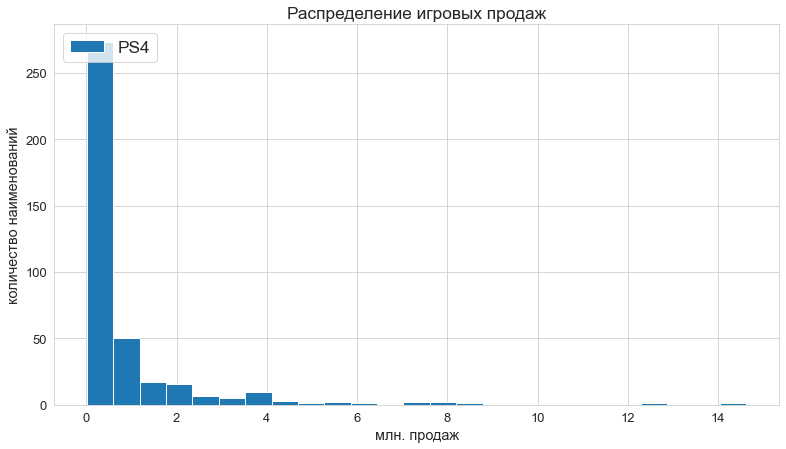

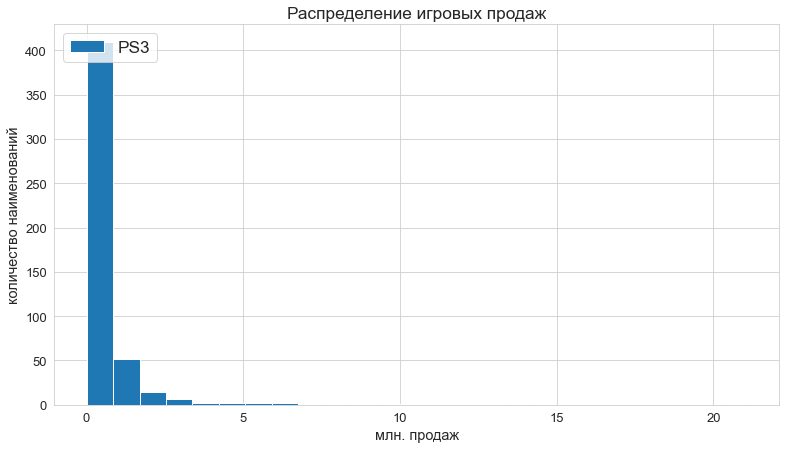

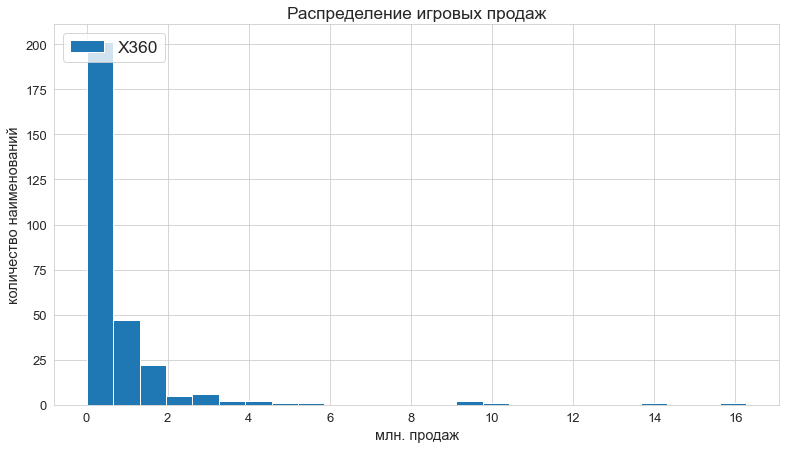

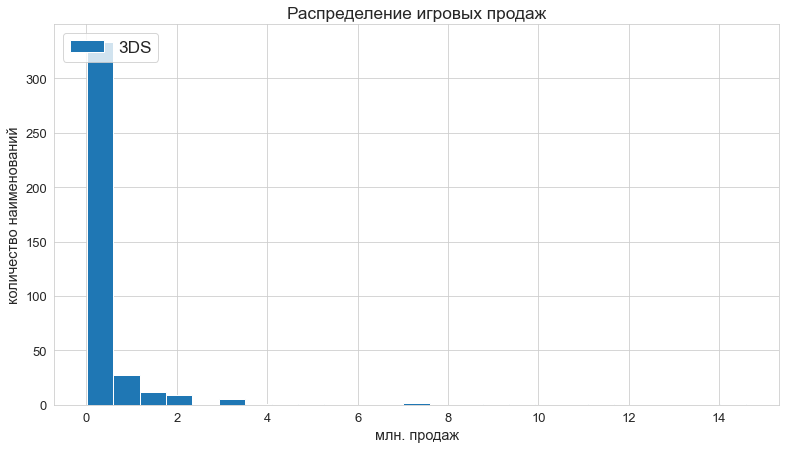

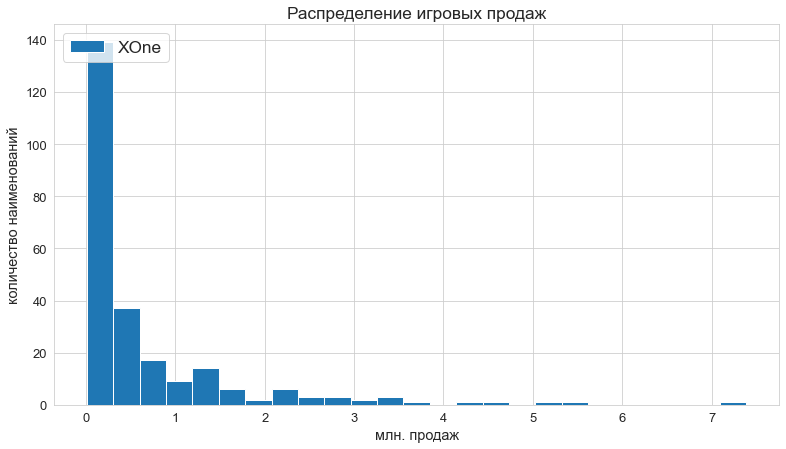

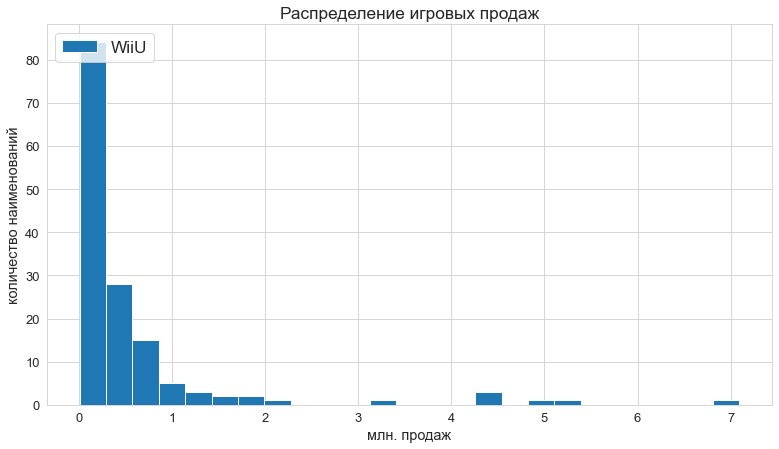

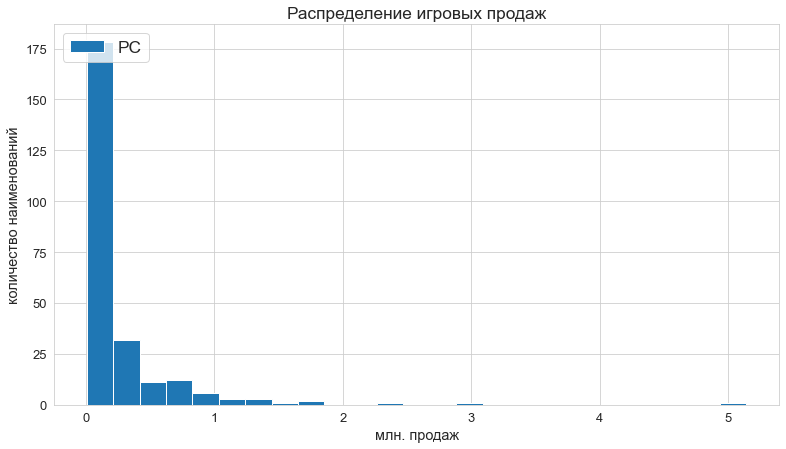

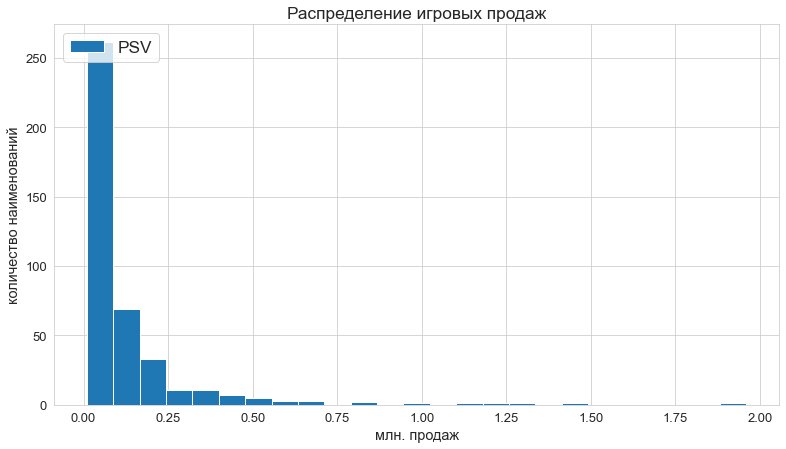

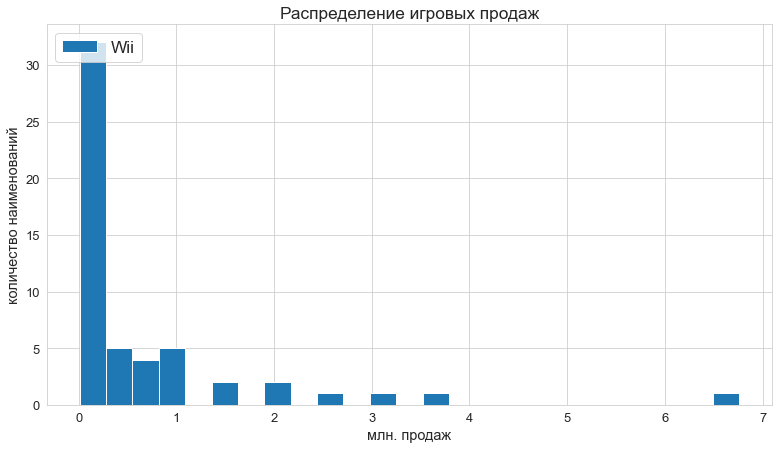

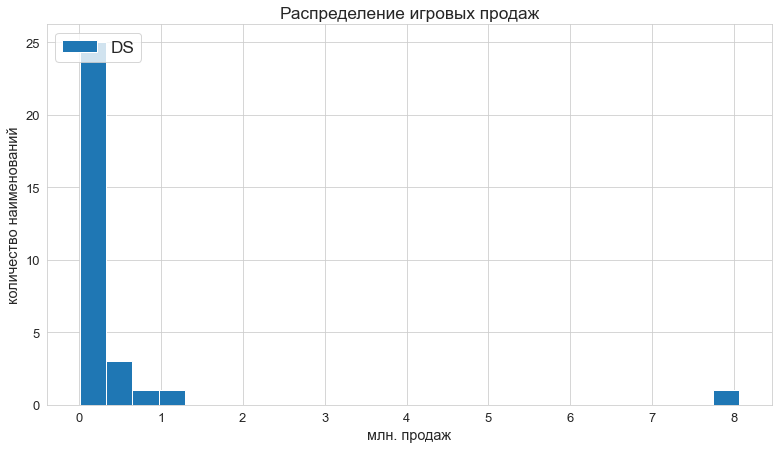

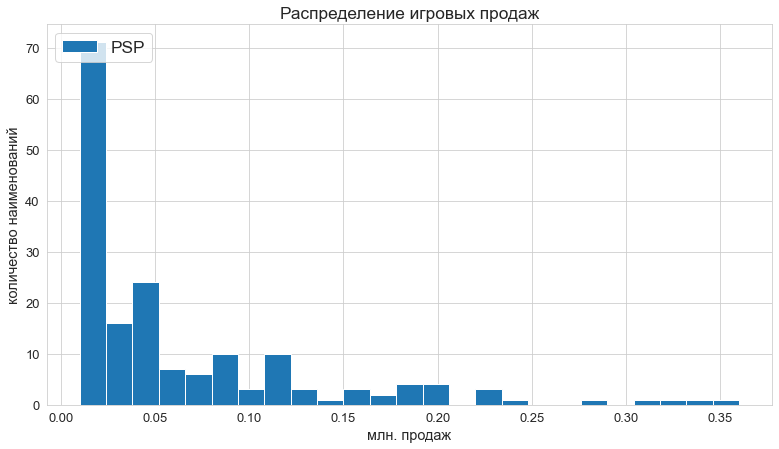

In [25]:
global_sales = {}

for platform in pivot_platforms_top_new.index:
    games = data_games_new.loc[data_games_new['platform'] == platform, 'sum_sales']
    global_sales[platform] = games
    
    plt.figure(figsize=(13, 7))
    plt.hist(games, bins = 25, label=platform)
    plt.title('Распределение игровых продаж', fontsize="xx-large")
    plt.legend(loc='upper left', fontsize="xx-large")
    plt.xlabel('млн. продаж', fontsize="x-large")
    plt.ylabel('количество наименований', fontsize="x-large")
    plt.xticks(size = 13)
    plt.yticks(size = 13)
    plt.show()

И боксплот:

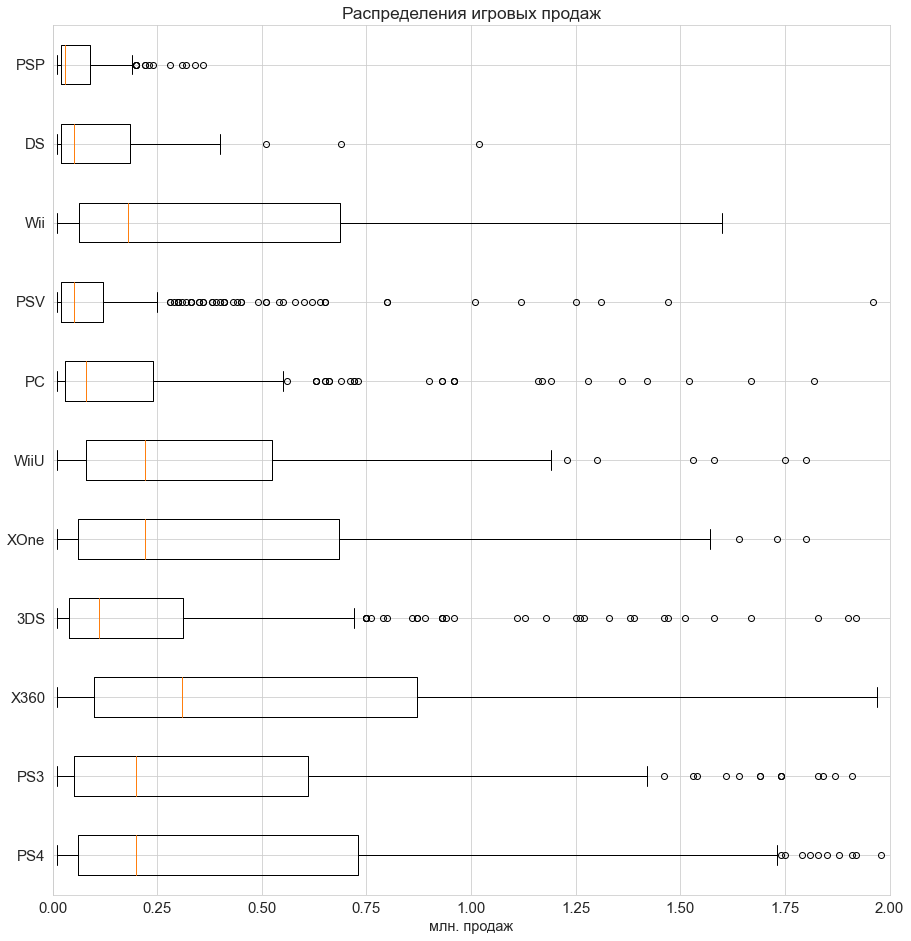

In [26]:
plt.figure(figsize=(15, 16))
plt.boxplot([global_sales['PS4'], global_sales['PS3'], global_sales['X360'], global_sales['3DS'],
             global_sales['XOne'], global_sales['WiiU'], global_sales['PC'], global_sales['PSV'], 
             global_sales['Wii'], global_sales['DS'], global_sales['PSP']], vert=False, 
            labels=['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS',
       'PSP'])
plt.title('Распределения игровых продаж', fontsize="xx-large")
plt.xlabel('млн. продаж', fontsize="x-large")
plt.xlim(0,2)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Смысл здесь в следующем: в разрезе платформ **подавляющее большинство игр не продаётся и полумиллионом экземпляров**. Все распределения выглядят похоже: огроменный максимум в начале, резкое снижение - и некое количество "выбросов-бестселлеров". Но здесь стоит учитывать, что мы смотрим только относительно новые игры, то есть не учитываем "лонгселлерство": ситуацию, когда игра (любой продукт в целом) живёт долго и продаётся - долго. Распределения по _всем_ играм могут быть смещены вправо - но вряд ли сильно.

Переходим к **корреляции между отзывами и продажами**. Смотреть будем на примере многообещающей `PS4`, на которой уже и тайтлов должно набраться достаточно для анализа. Вытащим игры, для которых информация об оценке критиков и пользователей есть:

In [27]:
critics_new = data_games_new.query('platform == "PS4" and critic_score >= 0')
users_new = data_games_new.query('platform == "PS4" and user_score >= 0')

#посмотрим на размеры выборок
print(f'с оценками критиков - {critics_new.shape[0]}, с оценками пользователей - {users_new.shape[0]}')

с оценками критиков - 252, с оценками пользователей - 257


И посмотрим на диаграммы рассеяния:

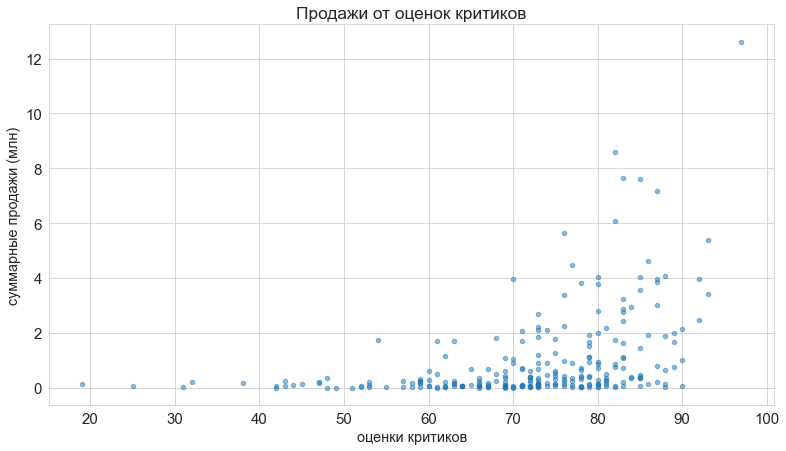

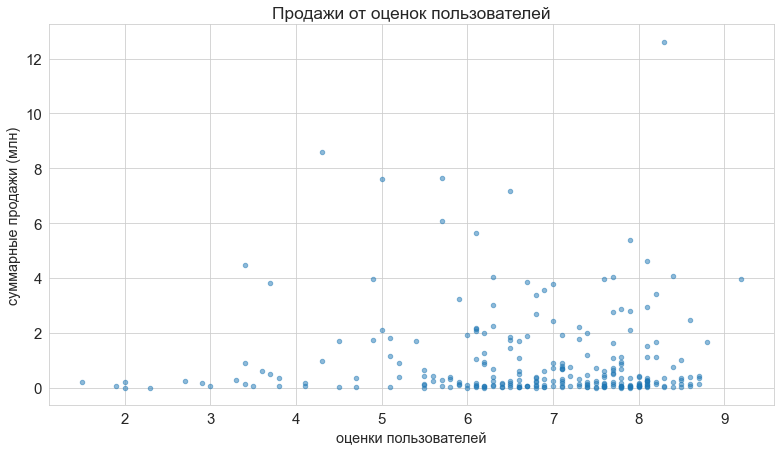

In [28]:
critics_new.plot(
    x='critic_score', 
    y='sum_sales', 
    kind='scatter', grid=True, figsize=(13, 7), alpha=0.5)
plt.xlabel('оценки критиков', fontsize="x-large")
plt.ylabel('суммарные продажи (млн)', fontsize="x-large")
plt.title(label='Продажи от оценок критиков', fontsize="xx-large")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

users_new.plot(
    x='user_score', 
    y='sum_sales', 
    kind='scatter', grid=True, figsize=(13, 7), alpha=0.5)
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('суммарные продажи (млн)', fontsize="x-large")
plt.title(label='Продажи от оценок пользователей', fontsize="xx-large")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Ндэ. Не очень-то похоже, что корреляция есть - что, впрочем, ожидаемо, учитывая предыдущий вывод (большинство игр не продаются и полумиллионом экземпляров). 

Особого смысла считать здесь я не вижу, но почему бы и нет:

In [29]:
critics_corr = critics_new['critic_score'].corr(critics_new['sum_sales'])
print(f'Критики: {critics_corr: .4f}')
users_corr = users_new['user_score'].corr(users_new['sum_sales'])
print(f'Пользователи: {users_corr: .4f}')

Критики:  0.4066
Пользователи: -0.0320


О пользователях вообще говорить нечего, а отзывы критиков и продажи коррелируют слабо - говорить о связи, которую стоит брать в расчёт, я бы не стала. И вряд ли для других платформ эта картина будет иной: у всех платформ подавляющее большинство игр не продаётся и полумиллионом эклемпляров, так что сильной линейной связи взяться просто неоткуда - в основном точки будут лежать **внизу**-справа (любопытно, что большинство игр оценивается пользователями и критиками как "плюс-минус прилично или лучше" - игр, которые люди оценивают как "совсем плохие", довольно мало).

Посмотрим, что у нас с **жанрами**:

In [30]:
genres_new = data_games_new.pivot_table(index='genre', values='sum_sales', aggfunc='sum').sort_values(
    by='sum_sales', ascending=False)

display(genres_new)

,sum_sales
genre,
Action,441.47
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04
Platform,61.00
Racing,53.50
Fighting,44.49
Simulation,35.12


Если смотреть суммарно, то экшн побеждает безоговорочно - вместе с шутерами и РПГ он образует топ-3. В плохом состоянии паззлы (игры-головоломки) - это нишевые игры с небольшой аудиторией, как и стратегии - но стратегии в меньшей мере. Однако здесь стоит посмотреть на количество игр в каждом жанре: 

In [31]:
genres_count = data_games_new.pivot_table(index='genre', values='name', aggfunc='count').sort_values(
    by='name', ascending=False)

display(genres_count)

,name
genre,
Action,1032
Role-Playing,370
Adventure,302
Sports,268
Shooter,235
Misc,192
Racing,115
Fighting,109
Platform,85


Как бы паззлы и стратегии продаются хуже всего - но их и выходит мало. Посмотрим медиану:

In [32]:
genres_median = data_games_new.pivot_table(index='genre', values='sum_sales', aggfunc='median').sort_values(
    by='sum_sales', ascending=False)

display(genres_median)

,sum_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


Победитель экшн - не такой уж и победитель, его просто много, он "берёт количеством". Шутеров по количеству заметно меньше, но продаются они лучше - можно предположить большую востребованность. Так же на удивление востребованы платформеры - при общем выводе "большинство игр не продаются и полумиллионом экземпляров" у них хорошие результаты. Стратегии и паззлы всё равно находятся в грустном положении - но не настолько грустном, как адвенчуры.

### <center>Портреты пользователей по регионам</center>

Посмотрим, какие платформы популярны в разрезе регионов:

In [33]:
platforms = data_games_new.pivot_table(
    index='platform', values=['eu_sales', 'na_sales', 'jp_sales'], aggfunc='sum')

for column in platforms.columns:
    top = platforms.sort_values(by=column, ascending=False).head(5)
    print(f'{column}:')
    display(top[column])
    print()

eu_sales:


platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64


jp_sales:


platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64


na_sales:


platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

Вот с Японией всё ожидаемо: `3DS` и `WiiU` там популярны, потому что они от Нинтендо; конечно, Нинтендо - компания _международная_, но в целом неудивительно, что японцам ближе японцы. А вот почему Северная Америка выбирает в первую очередь ИксБокс, а Европа - Плойку, я ответить затрудняюсь - причём в первом месте речь идёт о разных поколениях. `PS4` является конкурентом `XOne`, а `X360` - `PS3`; `PS4` и `XOne` вышли примерно в одно время (2013) - и на европейском рынке `PS4` уже успела всё обогнать, а на североамериканском - нет. При этом `XOne` на североамериканском рынке в разрезе топ-5 также плетётся "в хвосте", то есть "старая" Иксбокс-консоль понравилась американцам настолько, что её - как минимум, пока что - ничто не обгоняет, а к новой они более равнодушны.

Почему так - я не знаю. Примем как факт реальности - и перейдём к **жанрам**:

In [34]:
genres = data_games_new.pivot_table(
    index='genre', values=['eu_sales', 'na_sales', 'jp_sales'], aggfunc='sum')

for column in genres.columns:
    top = genres.sort_values(by=column, ascending=False).head(5)
    print(f'{column}:')
    display(top[column])
    print()

eu_sales:


genre
Action          159.59
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64


jp_sales:


genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64


na_sales:


genre
Action          177.90
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

Здесь европейский и североамериканский рынки почти идентичны: разница только в последнем месте - гонки у европецев и "всякое разное" (под Misc здесь скорее всего понимается Miscellaneous, то есть "прочее/невошедшее в другие категории") у американцев. Японцы же к шутерам и спортивной тематике относятся более прохладно: и те, и другие даже в топ-5 не вошли - а вот РПГ вышли на первое место. Также японцам импонируют игры-симуляции и файтинги. "Общим фаворитом", то есть жанром, показывающим очень высокие результаты на всех рынках, является экшн.

А теперь посмотрим медианы:

In [35]:
genres_mean = data_games_new.pivot_table(
    index='genre', values=['eu_sales', 'na_sales', 'jp_sales'], aggfunc='median')

for column in genres_mean.columns:
    top = genres_mean.sort_values(by=column, ascending=False).head(5)
    print(f'{column}:')
    display(top[column])
    print()

eu_sales:


genre
Shooter       0.17
Racing        0.09
Platform      0.08
Sports        0.05
Simulation    0.03
Name: eu_sales, dtype: float64


jp_sales:


genre
Role-Playing    0.06
Fighting        0.03
Misc            0.02
Action          0.01
Adventure       0.01
Name: jp_sales, dtype: float64


na_sales:


genre
Shooter     0.20
Platform    0.09
Sports      0.08
Fighting    0.05
Racing      0.04
Name: na_sales, dtype: float64

Здесь экшн вообще уехал из топа - у европейцев и американцев побеждают шутеры, спорт/гонки и платформы, а у японцев - РПГ, файтинги и разное.

Перейдём к **ESRB-рейтингам** - проблема устаревших рейтингов решилась сама собой. Посмотрим, как распределяются продажи по рейтингам в разных регионах:

In [36]:
ratings_table_full = data_games_new.pivot_table(
    index='rating', values=['eu_sales', 'na_sales', 'jp_sales'], aggfunc='sum')
display(ratings_table_full)

,eu_sales,jp_sales,na_sales
rating,,,
-1,91.50,108.84,103.31
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,194.21,21.20,231.63
T,52.96,26.02,66.02


Здесь несколько сложно говорить уверенно, потому что неясно, чего нет: рейтинга или информации о нём. Предположим, что у большинства игр с "заглушкой" именно что нет рейтинга - тогда можно сделать вывод, что в целом людей это не смущает. У Европы и Северной Америки "безрейтинговые" игры занимают почётное третье место, а у Японии - вообще первое. 

## <center>Проверка гипотез</center>

### <center>Пользовательские рейтинги на XOne и PC</center>

Проверим гипотезы, связанные с пользовательским рейтингом - начнём с наличия разницы между пользовательскими рейтингами `XOne` и `PC`. Здесь нам понадобится расчёт дисперсии, чтобы выбрать между Стьюдентом и Уэлчем - напишем функцию, выводящую интересующие нас показатели (а также вспомним об уже написанной функции distr_iqr, считающей границы по межквартильному размаху):

In [37]:
def distr_description(distr):
    mean = distr.mean()
    var = np.var(distr, ddof=1) #дисперсия для выборки
    std = np.std(distr, ddof=1) #стандартное отклонение для выборки
    print(f'среднее - {mean: .3f}, дисперсия - {var: .3f}, стандартное отклонение - {std: .3f}')

И посмотрим, с чем мы имеем дело:

среднее -  6.521, дисперсия -  1.907, стандартное отклонение -  1.381
Левая граница:  3.250, правая граница:  10.050


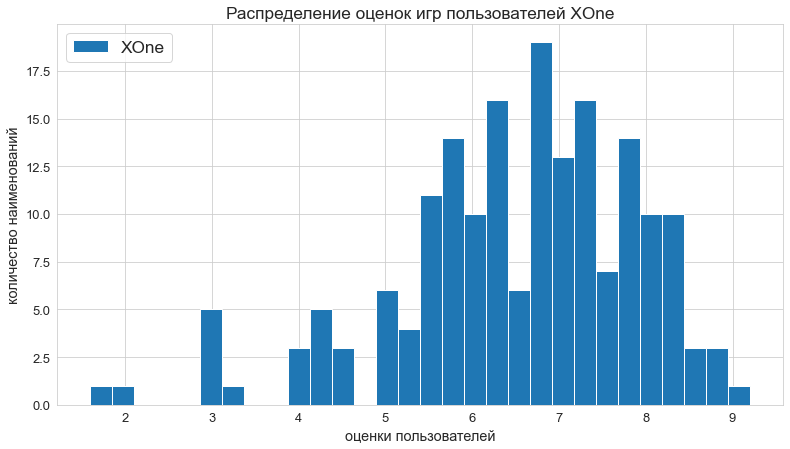

In [38]:
xone_ratings = data_games_new.query('platform == "XOne" and user_score >= 0')['user_score']
pc_ratings = data_games_new.query('platform == "PC" and user_score >= 0')['user_score']

#пользовательские рейтинги XOne
distr_description(xone_ratings)
distr_iqr(xone_ratings)
plt.figure(figsize=(13, 7))
plt.hist(xone_ratings, bins = 30, label=['XOne'])
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределение оценок игр пользователей XOne', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

среднее -  6.439, дисперсия -  2.778, стандартное отклонение -  1.667
Левая граница:  2.200, правая граница:  11.000


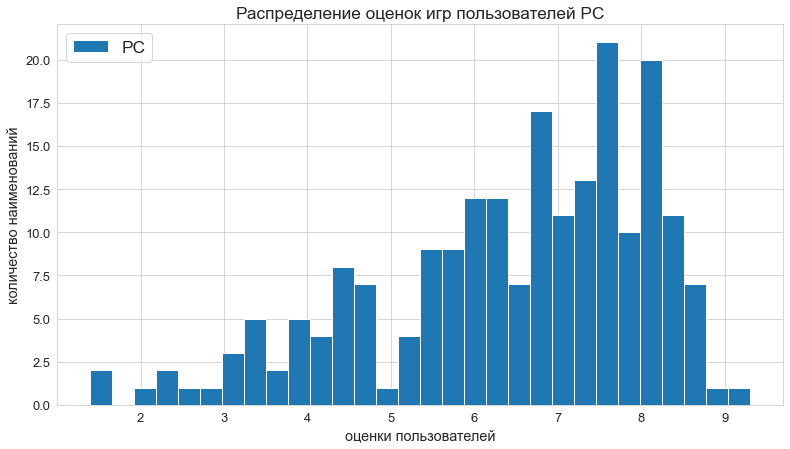

In [39]:
#пользовательские рейтинги PC
distr_description(pc_ratings)
distr_iqr(pc_ratings)
plt.figure(figsize=(13, 7))
plt.hist(pc_ratings, bins = 30, label=['PC'])
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределение оценок игр пользователей PC', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Тут, конечно, есть проблема: распределения явно скошенные, так что получится не особо аккуратно. Для начала посмотрим "глазами":

XOne: 182, PC: 207


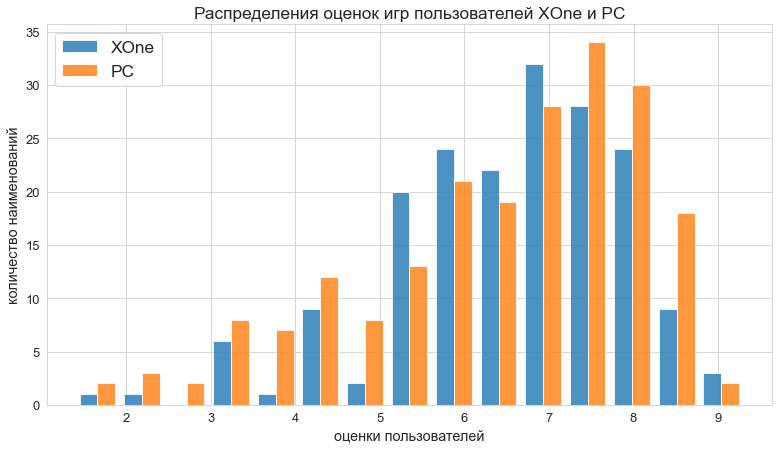

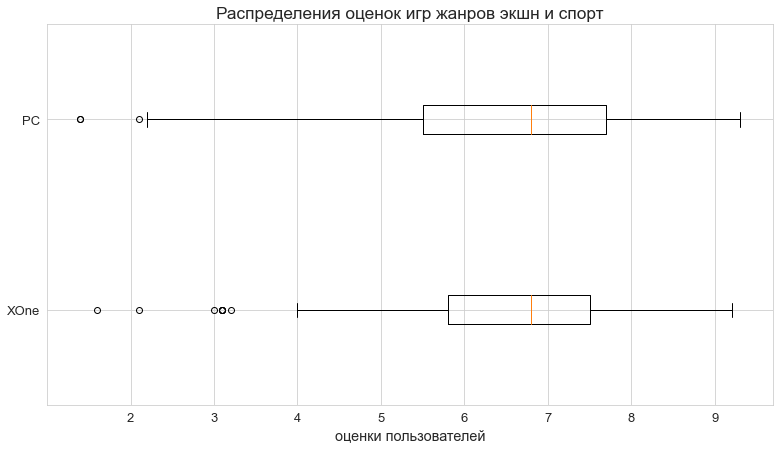

QQ-plot для XOne и PC:


C:\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


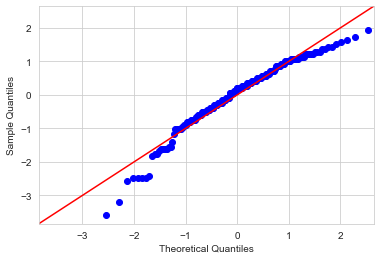

C:\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


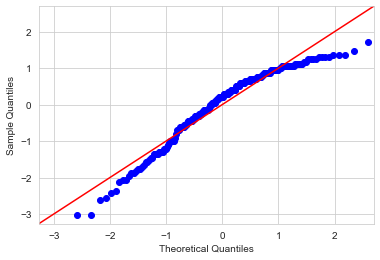

In [40]:
print(f'XOne: {xone_ratings.shape[0]}, PC: {pc_ratings.shape[0]}')

plt.figure(figsize=(13,7))
plt.hist([xone_ratings, pc_ratings], bins = 15, label=['XOne', 'PC'], alpha=0.8)
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределения оценок игр пользователей XOne и PC', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()
    
plt.figure(figsize=(13,7))
plt.boxplot([xone_ratings, pc_ratings], vert=False, labels=['XOne', 'PC'])
plt.title(label='Распределения оценок игр жанров экшн и спорт', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

print('QQ-plot для XOne и PC:')
sm.qqplot(xone_ratings, fit=True, line='45')
plt.show()
sm.qqplot(pc_ratings, fit=True, line='45')
plt.show()

PC совсем грустноватый, конечно - но ладно, сойдёт. Дальше выборки можно бы было привести к одному размеру, но здесь в любом случае больше хочется прогнать Уэлча - так что это необязательно. Глаза говорят, что разницы нет - посмотрим, что скажут числа.

**Нулевая гипотеза**: средние пользовательские рейтинги платформ Xbox One и PC равны; **альтернативная**, соответственно - средние не равны. Проводится **Т-тест Уэлча**.

In [41]:
results = st.ttest_ind(xone_ratings, pc_ratings, equal_var = False) 
print(results.pvalue)

0.5926118514134862


Да: p-value ожидаемо оказалось слишком велико, чтобы отвергуть нулевую гипотезу - **гипотеза о равенстве средних остаётся в силе**.

### <center>Пользовательские рейтинги жанров экшн и спорт</center>

Далее - всё то же самое для **экшна и спорта**:

среднее -  6.828, дисперсия -  1.891, стандартное отклонение -  1.375
Левая граница:  3.988, правая граница:  10.087


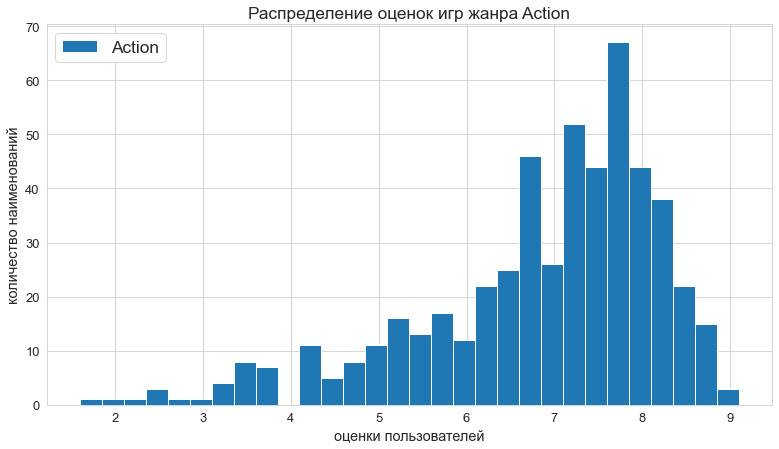

In [42]:
action_ratings = data_games_new.query('genre == "Action" and user_score >= 0')['user_score']
sport_ratings = data_games_new.query('genre == "Sports" and user_score >= 0')['user_score']

#пользовательские рейтинги экшна
distr_description(action_ratings)
distr_iqr(action_ratings)
plt.figure(figsize=(13, 7))
plt.hist(action_ratings, bins = 30, label=['Action'])
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределение оценок игр жанра Action', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

среднее -  5.456, дисперсия -  3.023, стандартное отклонение -  1.739
Левая граница:  0.550, правая граница:  10.550


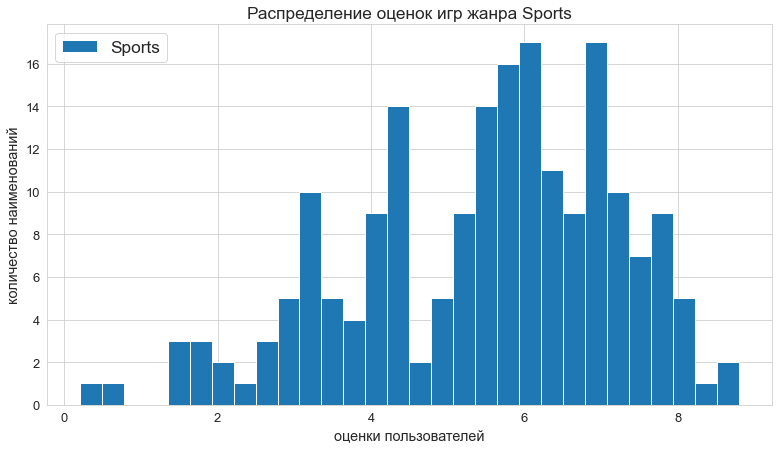

In [43]:
#пользовательские рейтинги спорта
distr_description(sport_ratings)
distr_iqr(sport_ratings)
plt.figure(figsize=(13, 7))
plt.hist(sport_ratings, bins = 30, label=['Sports'])
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределение оценок игр жанра Sports', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Посмотрим глазами:

Экшн: 524, Sport: 195


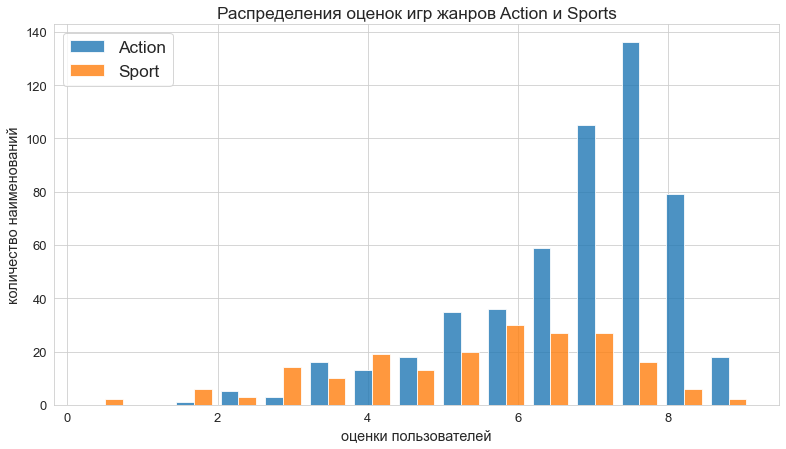

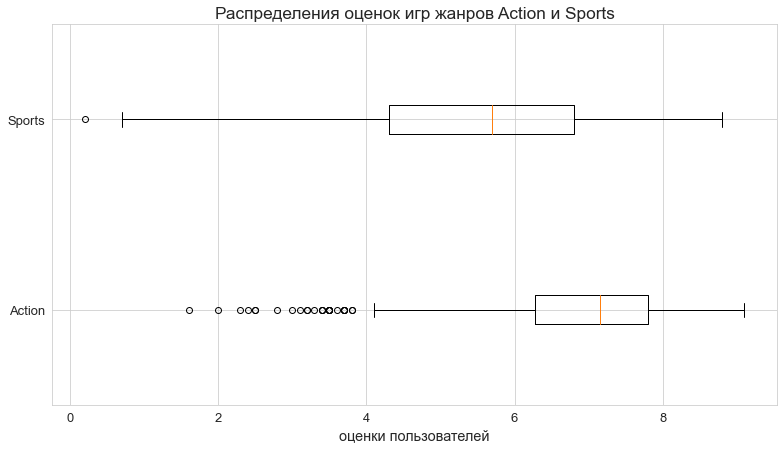

QQ-plot для экшна и спорта:


C:\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


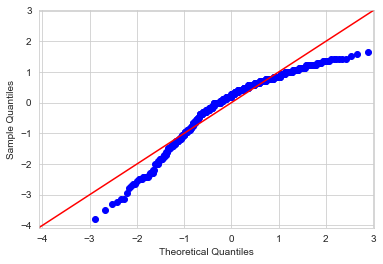

C:\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


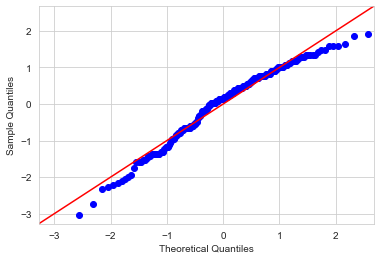

In [44]:
print(f'Экшн: {action_ratings.shape[0]}, Sport: {sport_ratings.shape[0]}')

plt.figure(figsize=(13,7))
plt.hist([action_ratings, sport_ratings], bins = 15, label=['Action', 'Sport'], alpha=0.8)
plt.legend(loc='upper left', fontsize="xx-large")
plt.title(label='Распределения оценок игр жанров Action и Sports', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.ylabel('количество наименований', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()
    
plt.figure(figsize=(13,7))
plt.boxplot([action_ratings, sport_ratings], vert=False, labels=['Action', 'Sports'])
plt.title(label='Распределения оценок игр жанров Action и Sports', fontsize="xx-large")
plt.xlabel('оценки пользователей', fontsize="x-large")
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

print('QQ-plot для экшна и спорта:')
sm.qqplot(action_ratings, fit=True, line='45')
plt.show()
sm.qqplot(sport_ratings, fit=True, line='45')
plt.show()

Экшн в плане нормальности делает несколько больно - но всё равно попробуем. Глазами в данном случае решить сложновато: средние кажутся разными (у экшна оно выше), но лучше посчитать - сделаем это:

**Нулевая гипотеза** как обычно - о равенстве: средние пользовательские рейтинги экшна и спорта равны; **альтернативная**, соответственно - средние не равны. Проводится **Т-тест Уэлча**.

In [45]:
results = st.ttest_ind(action_ratings, sport_ratings, equal_var = False) 
print(results.pvalue)

3.551295319559386e-20


Интуиция не подвела: p-value настолько мало, что сколько за границу ни бери, **гипотеза о равенстве средних отвергается**. Итого: средние пользовательские рейтинги платформ XOne и PC принимаются равными, а вот средние пользовательские рейтинги экшна и спорта - нет.

# <center>Общий вывод</center>

В среднем жизненный цикл игровых платформ (за исключением PC) составляет 7-10 лет. Исследование актуального времени показало, что перспективными платформами являются: `PS4` (очень перспективная!), `XOne`, `PC`, `3DS` (зона риска), `PCV`. 

Подавляющее большинство игр не продаются и полумиллионом экземпляров - корреляция продаж с оценками пользователей отсутствует, а с оценками критиков слаба достаточно, чтобы её можно было не принимать в расчёт. Любопытно, что большинство игр оцениваются людьми как "приличные или лучше" - откровенно плохих в глазах людей игр мало. 

Самыми прибыльными жанрами являются экшн, шутеры и РПГ, а самыми нишевыми - паззлы (игры-головоломки) и стратегии. 

Европейский и североамериканский рынки в целом похожи: в жанровых предпочтениях они вообще практически идентичны - но отличаются в предпочтениях консольных. Если на европейском рынке `PS4` успела обогнать всё остальное, то самой популярной платформой в Северной Америке остаётся `X360`. Япония же выделяется в принципе: на первом месте по предпочтениям у них находится РПГ (тогда как в Европе и Северной Америке этот жанр занимает только третье место), а к шутерам они сравнительно равнодушны - однако **экшн держится отлично на всех рынках** (однако он берёт количеством). В разрезе консолей же японцы предпочитают родную Нинтендо.

Средние пользовательские рейтинги платформ Xbox One и PC с большой вероятностью одинаковы, а вот средние оценки экшна и спорта - нет. 